In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#Import the required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.utils.data import DistributedSampler, DataLoader
import torch.nn as nn
import time
from copy import deepcopy
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import math

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# #Data of users from a video platform to be used as the source/training data
# video_data_path = '/content/drive/MyDrive/sbr_data_1M.csv'
# #Similar data but collected from articels to be used as the target/testing data
# #Zero percent cold data
# article_data_0_path = '/content/drive/MyDrive/cold_data.csv'
# #Thirty percent cold data
# article_data_03_path = '/content/drive/MyDrive/cold_data_0.3.csv'
# #Seventy percent cold data
# article_data_07_path = '/content/drive/MyDrive/cold_data_0.7.csv'
# #Hundered percent cold data
# article_data_1_path = '/content/drive/MyDrive/cold_data_1.csv'

In [4]:
#Data of users from a video platform to be used as the source/training data
video_data_path = 'sbr_data_1M.csv'
#Similar data but collected from articels to be used as the target/testing data
#Zero percent cold data
article_data_0_path = 'cold_data.csv'
#Thirty percent cold data
article_data_03_path = 'cold_data_0.3.csv'
#Seventy percent cold data
article_data_07_path = 'cold_data_0.7.csv'
#Hundered percent cold data
article_data_1_path = 'cold_data_1.csv'

In [5]:
#Read the data from the csv files
video_data = pd.read_csv(video_data_path)
article_data_0 = pd.read_csv(article_data_0_path)
article_data_03 = pd.read_csv(article_data_03_path)
article_data_07 = pd.read_csv(article_data_07_path)
article_data_1 = pd.read_csv(article_data_1_path)

C:\Users\HP\AppData\Local\Temp\ipykernel_6852\2301756399.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  video_data = pd.read_csv(video_data_path)


The preprocessing done to the data will be minimal as the goal here is to try to follow a similar dlow to the paper referenced which is
"Yuan, G., Yuan, F., Li, Y., Kong, B., Li, S., Chen, L., ... & Qie, X. (2022, December). Tenrec: A Large-scale Multipurpose Benchmark Dataset for Recommender Systems. In Advances in Neural Information Processing Systems (pp. 11480-11493). Curran Associates, Inc." and then find the  age and gender biases in the models and analyse the results.

In [6]:
#Check if any of the data contains duplicates or nulls
print("Video data shape: ", video_data.shape)
print("Video data total dublicates: ")
video_data.duplicated().sum()
print("Video data total nulls: ")
video_data.isna().sum()

print("article_data_0 shape: ", article_data_0.shape)
print("article_data_0 total dublicates: ")
article_data_0.duplicated().sum()
print("article_data_0 total nulls: ")
article_data_0.isna().sum()

print("article_data_03 shape: ", article_data_03.shape)
print("article_data_03 total dublicates: ")
article_data_03.duplicated().sum()
print("article_data_03 total nulls: ")
article_data_03.isna().sum()

print("article_data_07 shape: ", article_data_07.shape)
print("article_data_07 total dublicates: ")
article_data_07.duplicated().sum()
print("article_data_07 total nulls: ")
article_data_07.isna().sum()

print("article_data_1 shape: ", article_data_1.shape)
print("article_data_1 total dublicates: ")
article_data_1.duplicated().sum()
print("article_data_1 total nulls: ")
article_data_1.isna().sum()

Video data shape:  (38300254, 10)
Video data total dublicates: 


26455

Video data total nulls: 


user_id           0
item_id           0
click             0
follow            0
like              0
share             0
video_category    0
watching_times    0
gender            0
age               0
dtype: int64

article_data_0 shape:  (343305, 20)
article_data_0 total dublicates: 


3757

article_data_0 total nulls: 


user_id            0
item_id            0
click              0
gender             0
age                0
click_count        0
like_count         0
comment_count      0
read_percentage    0
item_score1        0
item_score2        0
category_second    0
category_first     0
item_score3        0
read               0
read_time          0
share              0
like               0
follow             0
favorite           0
dtype: int64

article_data_03 shape:  (2706527, 20)
article_data_03 total dublicates: 


113154

article_data_03 total nulls: 


user_id            0
item_id            0
click              0
gender             0
age                0
click_count        0
like_count         0
comment_count      0
read_percentage    0
item_score1        0
item_score2        0
category_second    0
category_first     0
item_score3        0
read               0
read_time          0
share              0
like               0
follow             0
favorite           0
dtype: int64

article_data_07 shape:  (1263750, 20)
article_data_07 total dublicates: 


49128

article_data_07 total nulls: 


user_id            0
item_id            0
click              0
gender             0
age                0
click_count        0
like_count         0
comment_count      0
read_percentage    0
item_score1        0
item_score2        0
category_second    0
category_first     0
item_score3        0
read               0
read_time          0
share              0
like               0
follow             0
favorite           0
dtype: int64

article_data_1 shape:  (206629, 20)
article_data_1 total dublicates: 


1633

article_data_1 total nulls: 


user_id            0
item_id            0
click              0
gender             0
age                0
click_count        0
like_count         0
comment_count      0
read_percentage    0
item_score1        0
item_score2        0
category_second    0
category_first     0
item_score3        0
read               0
read_time          0
share              0
like               0
follow             0
favorite           0
dtype: int64

In [7]:
#As there are duplicates found in all dataframes they will all be dropped
video_data.drop_duplicates(inplace = True)
article_data_0.drop_duplicates(inplace = True)
article_data_03.drop_duplicates(inplace = True)
article_data_07.drop_duplicates(inplace = True)
article_data_1.drop_duplicates(inplace = True)

In [8]:
#Display the dataframe information
video_data.info()
article_data_0.info()
article_data_03.info()
article_data_07.info()
article_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38273799 entries, 0 to 38300253
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   item_id         int64 
 2   click           int64 
 3   follow          int64 
 4   like            int64 
 5   share           int64 
 6   video_category  object
 7   watching_times  int64 
 8   gender          int64 
 9   age             int64 
dtypes: int64(9), object(1)
memory usage: 3.1+ GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 339548 entries, 0 to 343304
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          339548 non-null  int64  
 1   item_id          339548 non-null  int64  
 2   click            339548 non-null  float64
 3   gender           339548 non-null  int64  
 4   age              339548 non-null  int64  
 5   click_count      339548 non-null  int64  
 6   like_co

### As some of the actual columns are supposed to be categorical, in order to display the correct description for them those columns will be converted. One thing to be noted as the model requires all the values to be in their current format or else it will throw an error, the change will only be temporary to display the accurate data description.

In [9]:
# For the source data
video_data_for_info_only = video_data.copy()
video_data_for_info_only['video_category'] = video_data_for_info_only['video_category'].astype('category')

video_data_for_info_only['like'] = video_data_for_info_only['like'].astype('category')
video_data_for_info_only['follow'] = video_data_for_info_only['follow'].astype('category')

video_data_for_info_only['gender'] = video_data_for_info_only['gender'].astype('category')
video_data_for_info_only['age'] = video_data_for_info_only['age'].astype('category')
video_data_for_info_only['click'] = video_data_for_info_only['click'].astype('category')

video_data_for_info_only['user_id'] = video_data_for_info_only['user_id'].astype('category')
video_data_for_info_only['item_id'] = video_data_for_info_only['item_id'].astype('category')
video_data_for_info_only['share'] = video_data_for_info_only['share'].astype('category')

video_data_for_info_only.describe(include='all')

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age
count,38273799.0,38273799.0,38273799.0,38273799.0,38273799.0,38273799.0,38273799,3.827380e+07,38273799.0,38273799.0
unique,1000000.0,1197009.0,1.0,2.0,2.0,2.0,5,NaN,3.0,8.0
top,327480.0,779.0,1.0,0.0,0.0,0.0,0,NaN,1.0,2.0
freq,846.0,65262.0,38273799.0,38140363.0,36748472.0,38119630.0,20123789,NaN,22550091.0,18214195.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.490815e+00,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.067165e+00,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN


In [10]:
#For the target data with zero percent cold data
article_data_0_for_info_only = article_data_0.copy()

article_data_0_for_info_only['read'] = article_data_0_for_info_only['read'].astype('category')
article_data_0_for_info_only['share'] = article_data_0_for_info_only['share'].astype('category')
article_data_0_for_info_only['like'] = article_data_0_for_info_only['like'].astype('category')
article_data_0_for_info_only['follow'] = article_data_0_for_info_only['follow'].astype('category')
article_data_0_for_info_only['favorite'] = article_data_0_for_info_only['favorite'].astype('category')

article_data_0_for_info_only['gender'] = article_data_0_for_info_only['gender'].astype('category')
article_data_0_for_info_only['age'] = article_data_0_for_info_only['age'].astype('category')
article_data_0_for_info_only['click'] = article_data_0_for_info_only['click'].astype('category')

article_data_0_for_info_only['user_id'] = article_data_0_for_info_only['user_id'].astype('category')
article_data_0_for_info_only['item_id'] = article_data_0_for_info_only['item_id'].astype('category')

article_data_0_for_info_only.describe(include='all')

,user_id,item_id,click,gender,age,click_count,like_count,comment_count,read_percentage,item_score1,item_score2,category_second,category_first,item_score3,read,read_time,share,like,follow,favorite
count,339548.0,339548.0,339548.0,339548.0,339548.0,3.395480e+05,339548.000000,339548.000000,339548.000000,339548.000000,339548.000000,339548.000000,339548.000000,339548.000000,339548,339548.000000,339548,339548,339548,339548
unique,68661.0,55746.0,1.0,3.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2,2,2,2
top,11.0,145430.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,False,False,False,False
freq,5.0,644.0,339548.0,227755.0,162004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327160,NaN,335523,334784,339141,337401
mean,NaN,NaN,NaN,NaN,NaN,1.559108e+05,2255.536425,876.482324,50.989901,3.009142,3.080551,11408.989271,114.370708,4.569813,NaN,58.726474,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.335730e+05,6815.996462,1696.164028,29.227272,0.761926,0.641084,1459.757237,13.597574,3.035094,NaN,80.625338,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.763500e+04,97.000000,78.000000,29.000000,3.000000,3.000000,10802.000000,108.000000,3.000000,NaN,9.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,5.794000e+04,364.000000,322.000000,48.000000,3.000000,3.000000,11201.000000,112.000000,5.000000,NaN,31.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.580970e+05,1370.000000,985.000000,68.000000,4.000000,3.000000,12107.000000,121.000000,6.000000,NaN,78.229633,NaN,NaN,NaN,NaN


In [11]:
#For the target data with thirty percent cold data
article_data_03_for_info_only = article_data_03.copy()

article_data_03_for_info_only['read'] = article_data_03_for_info_only['read'].astype('category')
article_data_03_for_info_only['share'] = article_data_03_for_info_only['share'].astype('category')
article_data_03_for_info_only['like'] = article_data_03_for_info_only['like'].astype('category')
article_data_03_for_info_only['follow'] = article_data_03_for_info_only['follow'].astype('category')
article_data_03_for_info_only['favorite'] = article_data_03_for_info_only['favorite'].astype('category')

article_data_03_for_info_only['gender'] = article_data_03_for_info_only['gender'].astype('category')
article_data_03_for_info_only['age'] = article_data_03_for_info_only['age'].astype('category')
article_data_03_for_info_only['click'] = article_data_03_for_info_only['click'].astype('category')

article_data_03_for_info_only['user_id'] = article_data_03_for_info_only['user_id'].astype('category')
article_data_03_for_info_only['item_id'] = article_data_03_for_info_only['item_id'].astype('category')

article_data_03_for_info_only.describe(include='all')

,user_id,item_id,click,gender,age,click_count,like_count,comment_count,read_percentage,item_score1,item_score2,category_second,category_first,item_score3,read,read_time,share,like,follow,favorite
count,2593373.0,2593373.0,2593373.0,2593373.0,2593373.0,2.593373e+06,2.593373e+06,2.593373e+06,2.593373e+06,2.593373e+06,2.593373e+06,2.593373e+06,2.593373e+06,2.593373e+06,2593373,2.593373e+06,2593373,2593373,2593373,2593373
unique,68661.0,121905.0,1.0,3.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2,2,2,2
top,916632.0,178939.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,False,False,False,False
freq,1386.0,4414.0,2593373.0,1778977.0,1234671.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2509530,NaN,2563339,2557270,2590839,2578671
mean,NaN,NaN,NaN,NaN,NaN,1.360437e+05,1.794327e+03,7.715973e+02,5.017448e+01,3.027339e+00,3.086401e+00,1.142124e+04,1.144743e+02,4.581211e+00,NaN,5.374436e+01,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.236523e+05,5.750824e+03,1.634068e+03,2.872574e+01,7.470438e-01,6.324736e-01,1.370147e+03,1.269437e+01,4.266172e+00,NaN,7.974374e+01,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.302600e+04,7.200000e+01,5.700000e+01,2.800000e+01,3.000000e+00,3.000000e+00,1.080200e+04,1.080000e+02,3.000000e+00,NaN,7.000000e+00,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,4.563500e+04,2.860000e+02,2.540000e+02,4.700000e+01,3.000000e+00,3.000000e+00,1.120100e+04,1.120000e+02,5.000000e+00,NaN,2.700000e+01,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.319790e+05,9.880000e+02,8.250000e+02,6.700000e+01,4.000000e+00,3.000000e+00,1.210300e+04,1.210000e+02,6.000000e+00,NaN,7.100000e+01,NaN,NaN,NaN,NaN


In [12]:
#For the target data with seventy percent cold data
article_data_07_for_info_only = article_data_07.copy()

article_data_07_for_info_only['read'] = article_data_07_for_info_only['read'].astype('category')
article_data_07_for_info_only['share'] = article_data_07_for_info_only['share'].astype('category')
article_data_07_for_info_only['like'] = article_data_07_for_info_only['like'].astype('category')
article_data_07_for_info_only['follow'] = article_data_07_for_info_only['follow'].astype('category')
article_data_07_for_info_only['favorite'] = article_data_07_for_info_only['favorite'].astype('category')

article_data_07_for_info_only['gender'] = article_data_07_for_info_only['gender'].astype('category')
article_data_07_for_info_only['age'] = article_data_07_for_info_only['age'].astype('category')
article_data_07_for_info_only['click'] = article_data_07_for_info_only['click'].astype('category')

article_data_07_for_info_only['user_id'] = article_data_07_for_info_only['user_id'].astype('category')
article_data_07_for_info_only['item_id'] = article_data_07_for_info_only['item_id'].astype('category')

article_data_07_for_info_only.describe(include='all')

,user_id,item_id,click,gender,age,click_count,like_count,comment_count,read_percentage,item_score1,item_score2,category_second,category_first,item_score3,read,read_time,share,like,follow,favorite
count,1214622.0,1214622.0,1214622.0,1214622.0,1214622.0,1.214622e+06,1.214622e+06,1.214622e+06,1.214622e+06,1.214622e+06,1.214622e+06,1.214622e+06,1.214622e+06,1.214622e+06,1214622,1.214622e+06,1214622,1214622,1214622,1214622
unique,68661.0,95933.0,1.0,3.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2,2,2,2
top,819433.0,178939.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,False,False,False,False
freq,976.0,2138.0,1214622.0,828779.0,581598.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1173993,NaN,1200537,1197878,1213570,1207596
mean,NaN,NaN,NaN,NaN,NaN,1.385008e+05,1.844415e+03,7.819126e+02,5.035153e+01,3.028539e+00,3.085788e+00,1.141439e+04,1.144051e+02,4.575986e+00,NaN,5.457993e+01,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.262731e+05,5.854209e+03,1.625526e+03,2.885661e+01,7.473533e-01,6.358638e-01,1.383343e+03,1.284034e+01,4.207978e+00,NaN,7.784686e+01,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.345825e+04,7.300000e+01,5.900000e+01,2.900000e+01,3.000000e+00,3.000000e+00,1.080200e+04,1.080000e+02,3.000000e+00,NaN,7.000000e+00,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,4.707500e+04,2.930000e+02,2.620000e+02,4.700000e+01,3.000000e+00,3.000000e+00,1.120100e+04,1.120000e+02,5.000000e+00,NaN,2.740491e+01,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.346530e+05,1.019000e+03,8.410000e+02,6.700000e+01,4.000000e+00,3.000000e+00,1.210300e+04,1.210000e+02,6.000000e+00,NaN,7.236723e+01,NaN,NaN,NaN,NaN


In [13]:
#For the target data with hundred percent cold data
article_data_1_for_info_only = article_data_1.copy()

article_data_1_for_info_only['read'] = article_data_1_for_info_only['read'].astype('category')
article_data_1_for_info_only['share'] = article_data_1_for_info_only['share'].astype('category')
article_data_1_for_info_only['like'] = article_data_1_for_info_only['like'].astype('category')
article_data_1_for_info_only['follow'] = article_data_1_for_info_only['follow'].astype('category')
article_data_1_for_info_only['favorite'] = article_data_1_for_info_only['favorite'].astype('category')

article_data_1_for_info_only['gender'] = article_data_1_for_info_only['gender'].astype('category')
article_data_1_for_info_only['age'] = article_data_1_for_info_only['age'].astype('category')
article_data_1_for_info_only['click'] = article_data_1_for_info_only['click'].astype('category')

article_data_1_for_info_only['user_id'] = article_data_1_for_info_only['user_id'].astype('category')
article_data_1_for_info_only['item_id'] = article_data_1_for_info_only['item_id'].astype('category')

article_data_1_for_info_only.describe(include='all')

,user_id,item_id,click,gender,age,click_count,like_count,comment_count,read_percentage,item_score1,item_score2,category_second,category_first,item_score3,read,read_time,share,like,follow,favorite
count,204996.0,204996.0,204996.0,204996.0,204996.0,2.049960e+05,204996.000000,204996.000000,204996.000000,204996.000000,204996.000000,204996.000000,204996.000000,204996.000000,204996,204996.000000,204996,204996,204996,204996
unique,68661.0,44331.0,1.0,3.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2,2,2,2
top,197042.0,8535.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,False,False,False,False
freq,5.0,490.0,204996.0,137667.0,97971.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197325,NaN,202580,202098,204737,203679
mean,NaN,NaN,NaN,NaN,NaN,1.575963e+05,2252.227707,880.663330,51.116973,3.008332,3.076182,11397.214799,114.233644,4.568045,NaN,59.076157,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.384879e+05,6867.510276,1702.661842,29.249662,0.765834,0.639364,1484.554490,13.928722,3.002089,NaN,80.976038,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.772200e+04,97.000000,79.000000,29.000000,3.000000,3.000000,10802.000000,108.000000,3.000000,NaN,9.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,5.822700e+04,364.000000,323.000000,48.000000,3.000000,3.000000,11201.000000,112.000000,5.000000,NaN,31.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.590800e+05,1357.000000,990.000000,68.000000,4.000000,3.000000,12105.000000,121.000000,6.000000,NaN,79.000000,NaN,NaN,NaN,NaN


### In order to be able to predict whether the data itself is biased, the distribution of the different age categories and genders needs to be compared.

In [14]:
# Calculate demographic distributions for each dataset
age_distribution_video_data = video_data['age'].value_counts()
age_distribution_article_data_0 = article_data_0['age'].value_counts()
age_distribution_article_data_03 = article_data_03['age'].value_counts()
age_distribution_article_data_07 = article_data_07['age'].value_counts()
age_distribution_article_data_1 = article_data_1['age'].value_counts()

gender_distribution_video_data = video_data['gender'].value_counts()
gender_distribution_article_data_0 = article_data_0['gender'].value_counts()
gender_distribution_article_data_03 = article_data_03['gender'].value_counts()
gender_distribution_article_data_07 = article_data_07['gender'].value_counts()
gender_distribution_article_data_1 = article_data_1['gender'].value_counts()

<Figure size 2000x800 with 0 Axes>

<AxesSubplot: >

<BarContainer object of 8 artists>

Text(0.5, 0, 'Age Group')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Age Distribution video_data')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot: >

([<matplotlib.patches.Wedge at 0x1ff694927d0>,
 [Text(-0.3041622364014568, 1.0571117887656274, '1'),
  Text(-0.3527294885571226, -1.0419126200897229, '2'),
  Text(0.90375550808538, -0.6270773330342415, '0')],
 [Text(-0.1659066744007946, 0.5766064302357967, '58.9%'),
  Text(-0.19239790284933958, -0.5683159745943942, '21.8%'),
  Text(0.4929575498647526, -0.3420421816550408, '19.3%')])

Text(0.5, 1.0, 'Gender Distribution video_data')

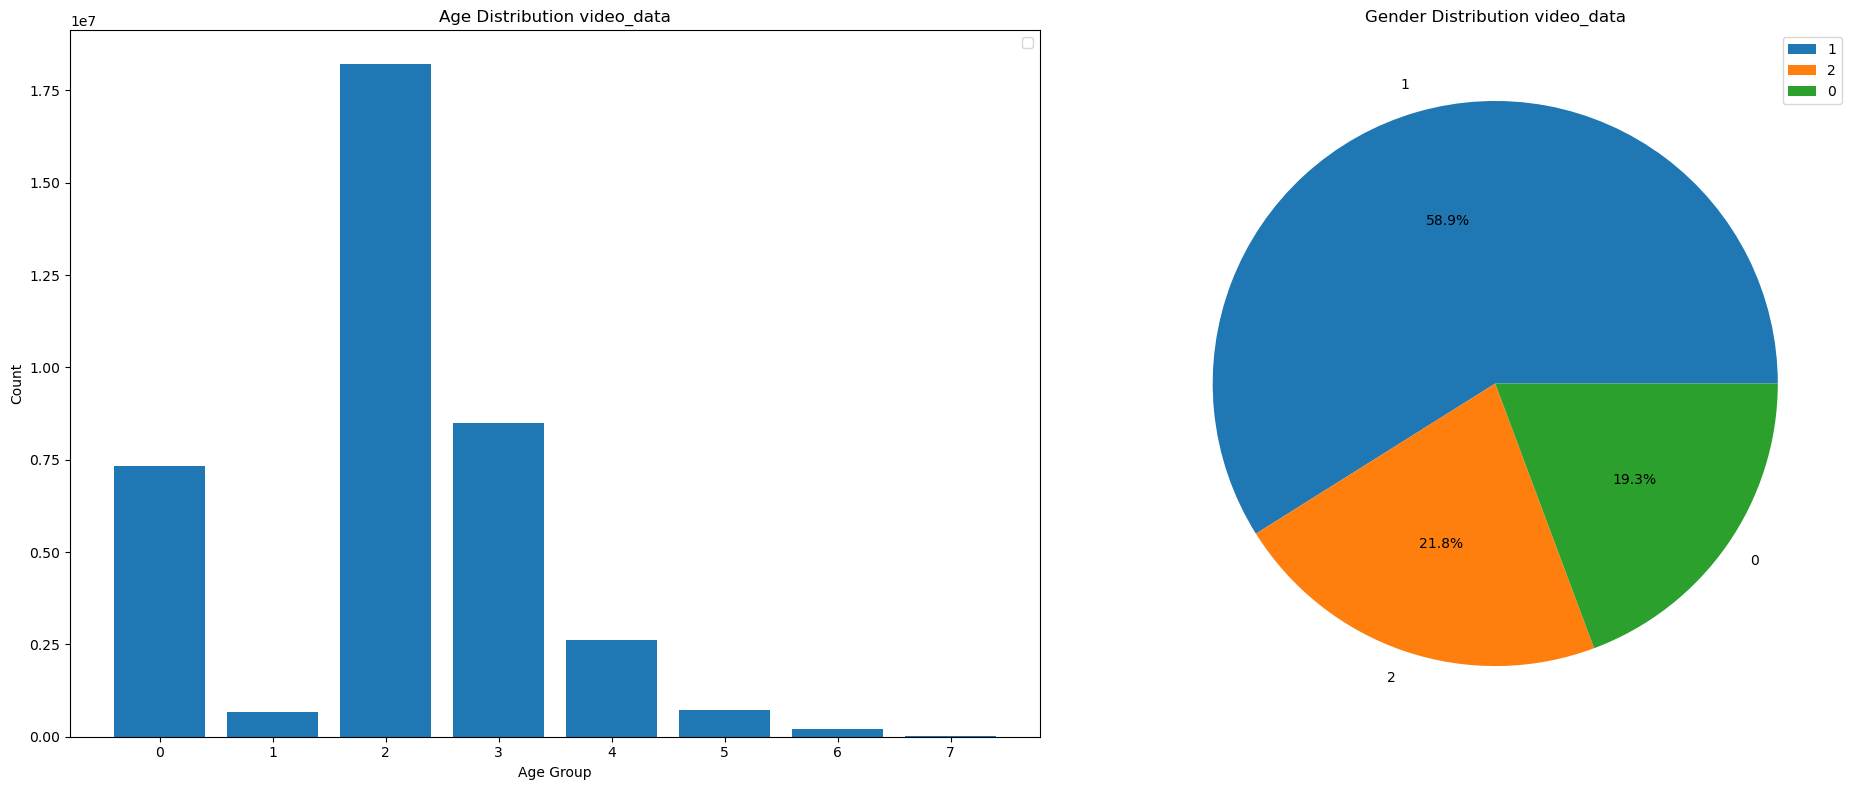

In [15]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.bar(age_distribution_video_data.index, age_distribution_video_data.values)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution video_data')
plt.legend()

plt.subplot(1, 2, 2)
plt.pie(gender_distribution_video_data.values, labels=gender_distribution_video_data.index, autopct='%1.1f%%')
plt.title('Gender Distribution video_data')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 2000x800 with 0 Axes>

<AxesSubplot: >

<BarContainer object of 8 artists>

Text(0.5, 0, 'Age Group')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Age Distribution article_data_0')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot: >

([<matplotlib.patches.Wedge at 0x2000d2fe7a0>,
 [Text(-0.5622027454416268, 0.9454776956744656, '1'),
  Text(0.5575158068371356, -0.9482489784475056, '2'),
  Text(1.0999865239959428, -0.005444908385217072, '0')],
 [Text(-0.30665604296816007, 0.5157151067315267, '67.1%'),
  Text(0.304099531002074, -0.5172267155168211, '32.8%'),
  Text(0.5999926494523323, -0.0029699500283002205, '0.2%')])

Text(0.5, 1.0, 'Gender Distribution article_data_0')

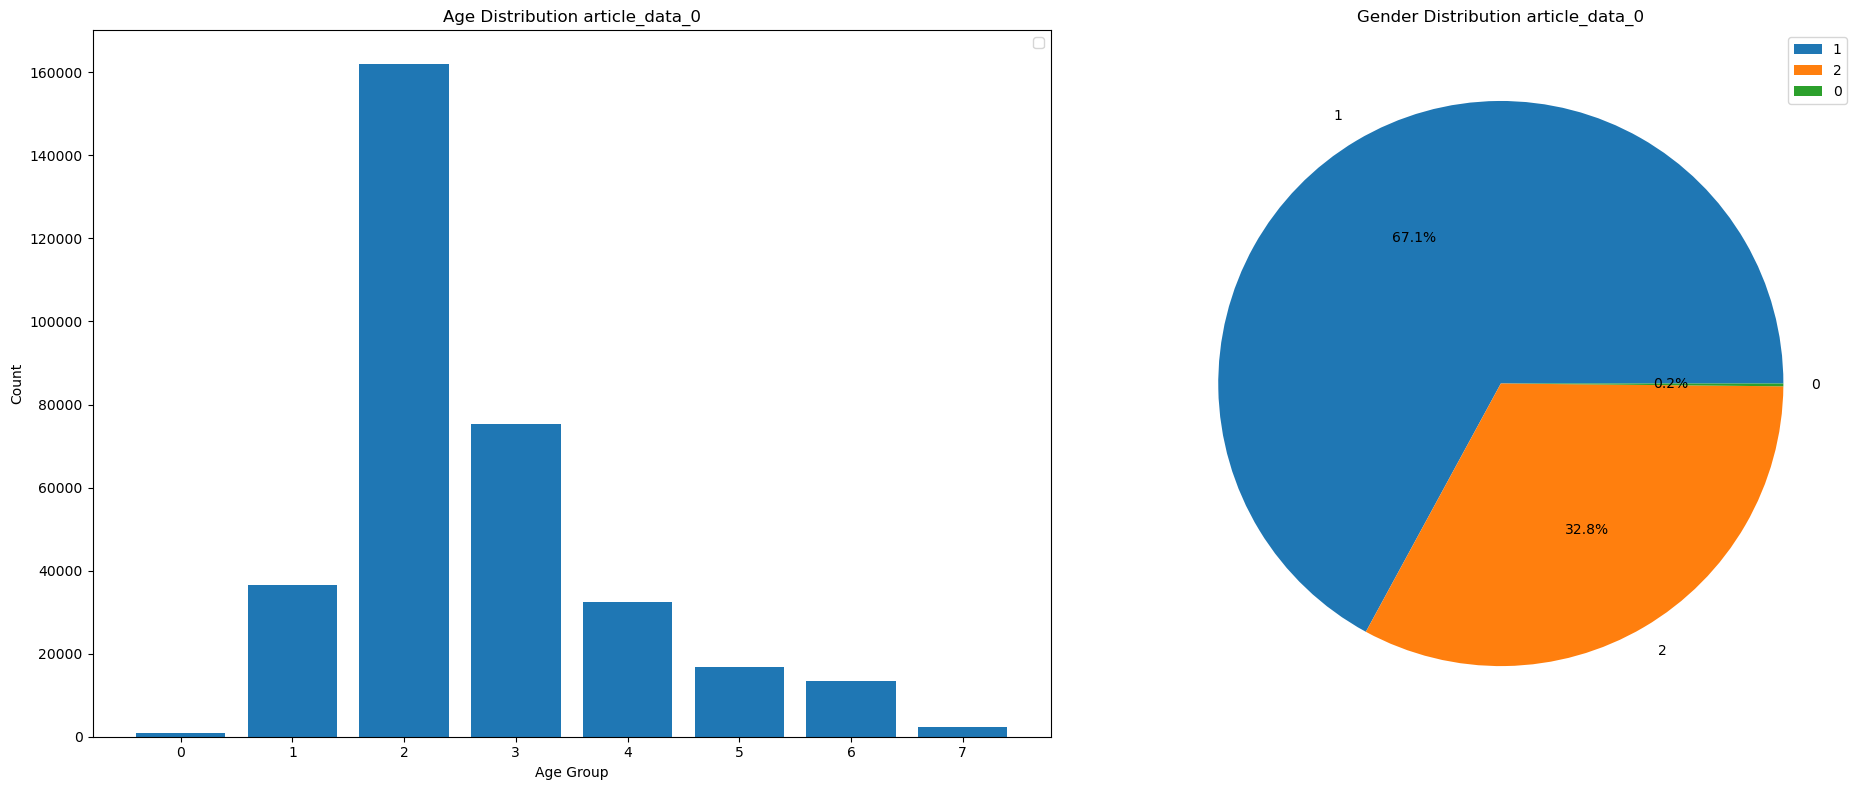

In [16]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.bar(age_distribution_article_data_0.index, age_distribution_article_data_0.values)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution article_data_0')
plt.legend()

plt.subplot(1, 2, 2)
plt.pie(gender_distribution_article_data_0.values, labels=gender_distribution_article_data_0.index, autopct='%1.1f%%')
plt.title('Gender Distribution article_data_0')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 2000x800 with 0 Axes>

<AxesSubplot: >

<BarContainer object of 8 artists>

Text(0.5, 0, 'Age Group')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Age Distribution article_data_03')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot: >

([<matplotlib.patches.Wedge at 0x2000d3ea6e0>,
 [Text(-0.6067250389672852, 0.9175427658099357, '1'),
  Text(0.6014387419217925, -0.9210165252130559, '2'),
  Text(1.0999818128721457, -0.006325452593127728, '0')],
 [Text(-0.3309409303457919, 0.5004778722599649, '68.6%'),
  Text(0.32805749559370495, -0.5023726501162122, '31.2%'),
  Text(0.5999900797484431, -0.00345024686897876, '0.2%')])

Text(0.5, 1.0, 'Gender Distribution article_data_03')

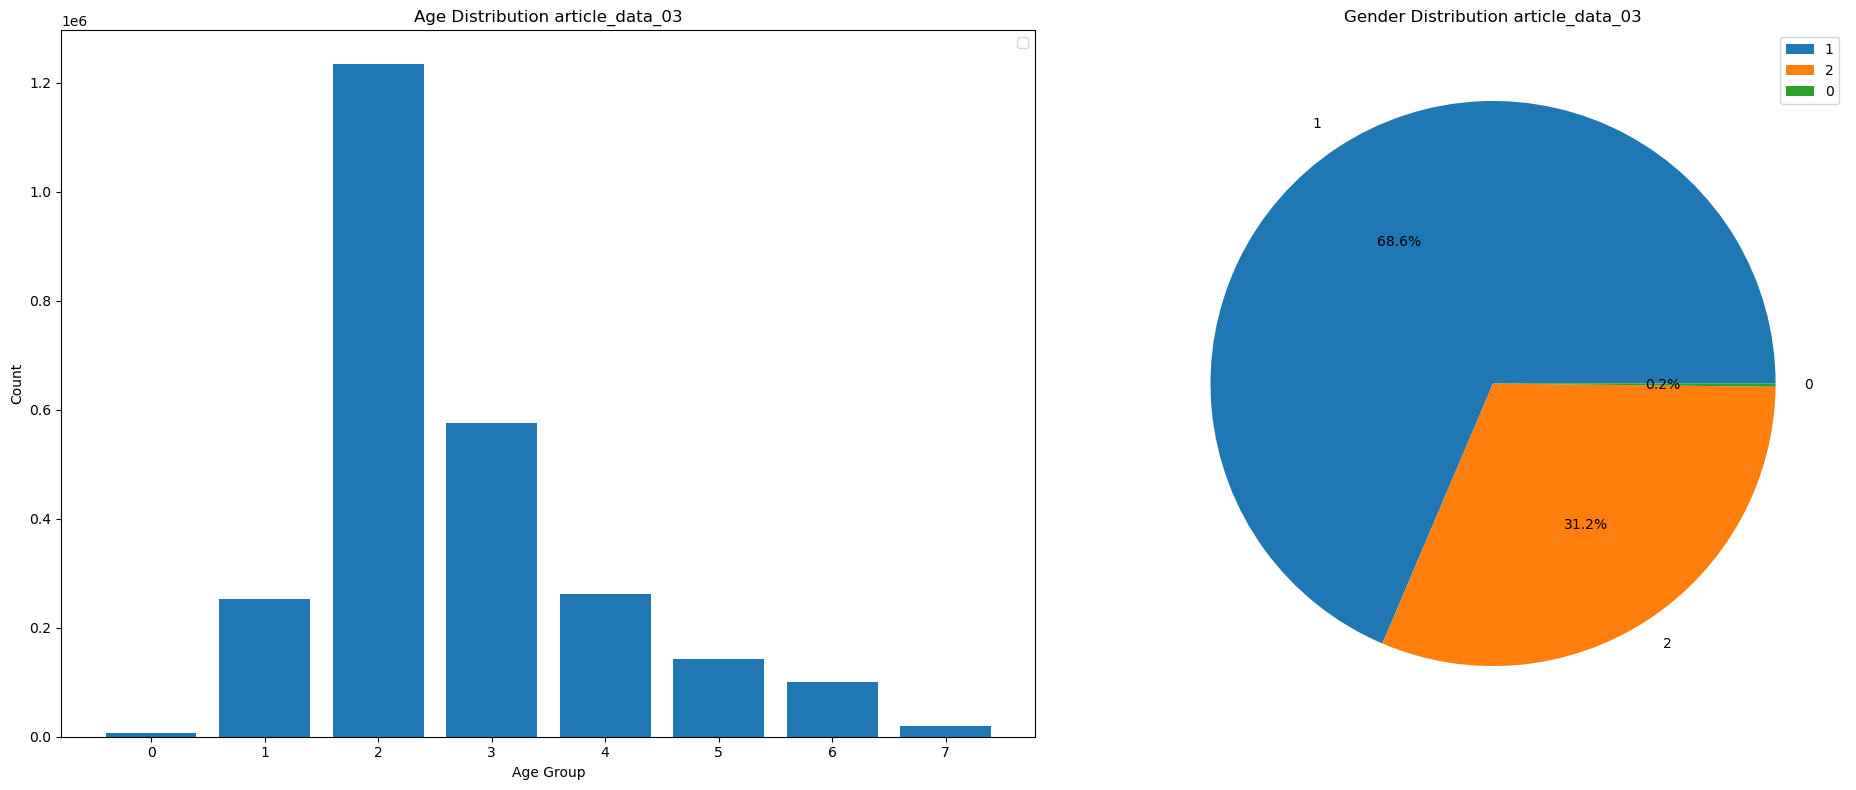

In [17]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.bar(age_distribution_article_data_03.index, age_distribution_article_data_03.values)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution article_data_03')
plt.legend()

plt.subplot(1, 2, 2)
plt.pie(gender_distribution_article_data_03.values, labels=gender_distribution_article_data_03.index, autopct='%1.1f%%')
plt.title('Gender Distribution article_data_03')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 2000x800 with 0 Axes>

<AxesSubplot: >

<BarContainer object of 8 artists>

Text(0.5, 0, 'Age Group')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Age Distribution article_data_07')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot: >

([<matplotlib.patches.Wedge at 0x2000d48ac80>,
 [Text(-0.596206298929599, 0.9244122722663681, '1'),
  Text(0.5885107815070115, -0.9293304364164593, '2'),
  Text(1.0999620863021262, -0.00913283624477724, '0')],
 [Text(-0.3252034357797812, 0.5042248757816553, '68.2%'),
  Text(0.32100588082200626, -0.5069075107726141, '31.5%'),
  Text(0.5999793198011597, -0.004981547042605766, '0.3%')])

Text(0.5, 1.0, 'Gender Distribution article_data_07')

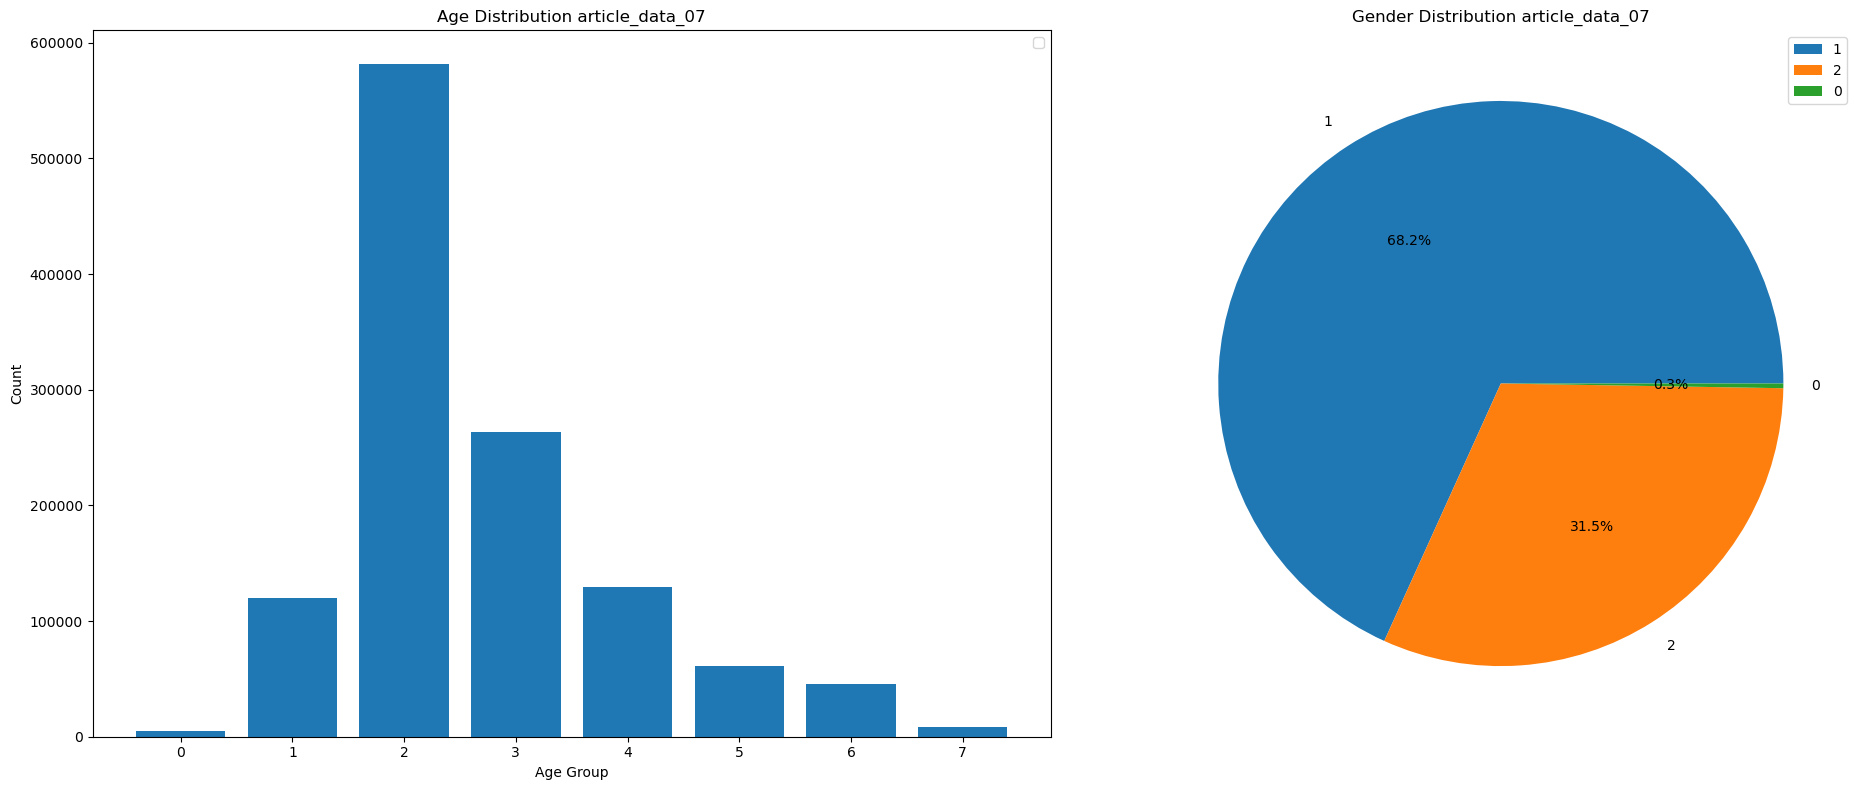

In [18]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.bar(age_distribution_article_data_07.index, age_distribution_article_data_07.values)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution article_data_07')
plt.legend()

plt.subplot(1, 2, 2)
plt.pie(gender_distribution_article_data_07.values, labels=gender_distribution_article_data_07.index, autopct='%1.1f%%')
plt.title('Gender Distribution article_data_07')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 2000x800 with 0 Axes>

<AxesSubplot: >

<BarContainer object of 8 artists>

Text(0.5, 0, 'Age Group')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Age Distribution article_data_1')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot: >

([<matplotlib.patches.Wedge at 0x2000d5c62c0>,
 [Text(-0.5645774289202871, 0.9440616117360977, '1'),
  Text(0.5604197112982817, -0.9465356555293365, '2'),
  Text(1.099989360278255, -0.004838106513468344, '0')],
 [Text(-0.30795132486561105, 0.5149426973105987, '67.2%'),
  Text(0.30568347888997177, -0.5162921757432745, '32.7%'),
  Text(0.5999941965154116, -0.002638967189164551, '0.1%')])

Text(0.5, 1.0, 'Gender Distribution article_data_1')

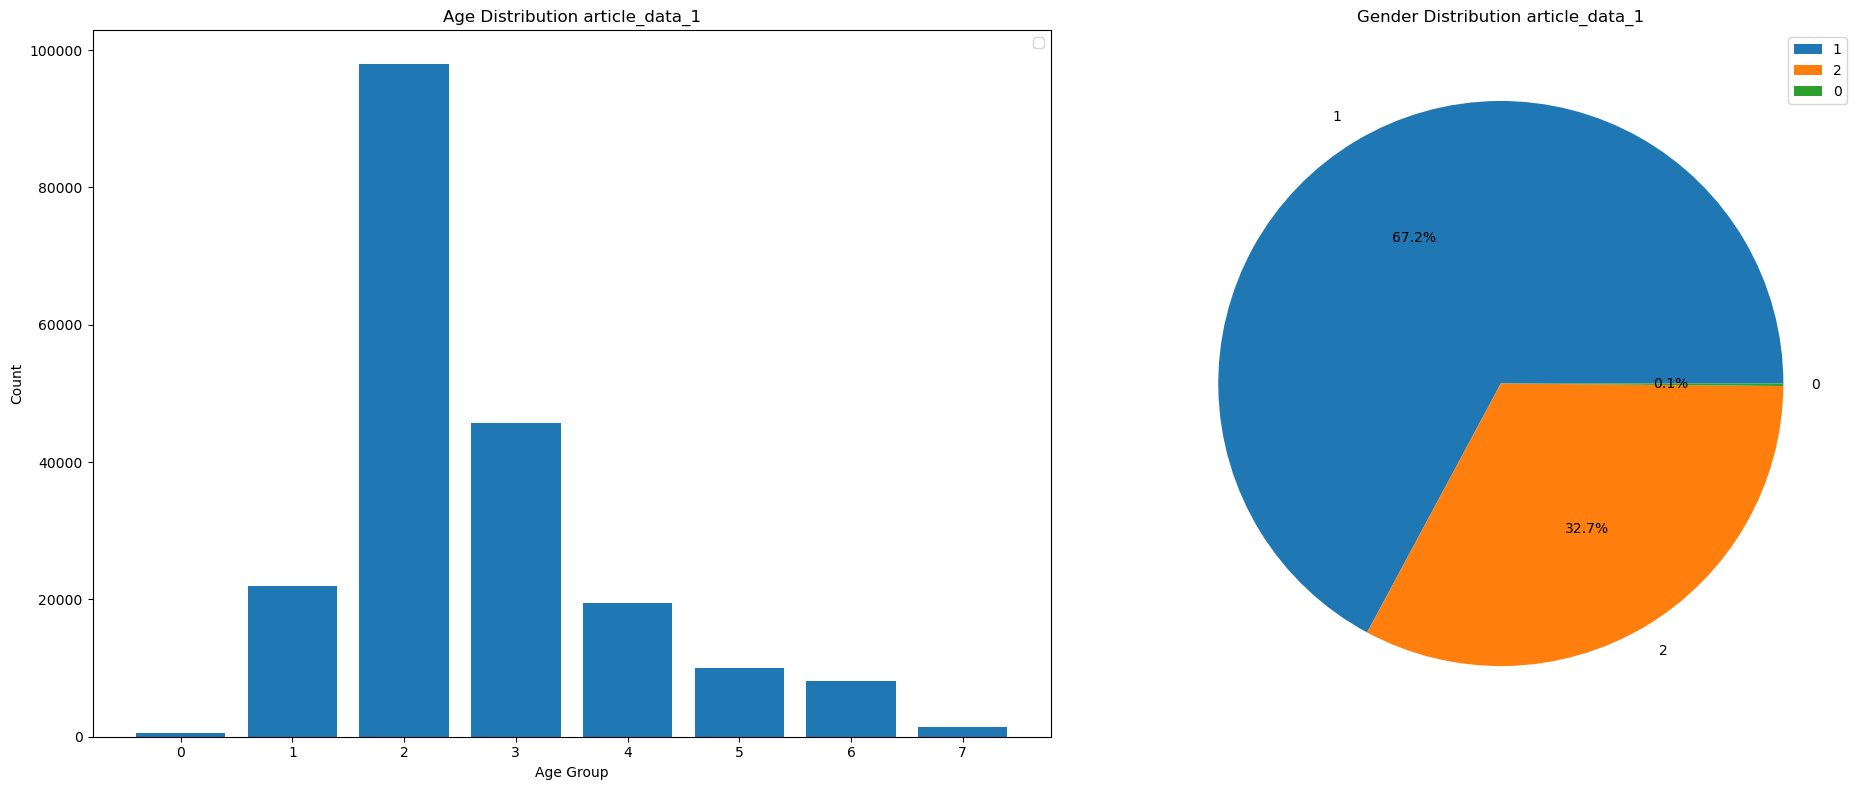

In [19]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.bar(age_distribution_article_data_1.index, age_distribution_article_data_1.values)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution article_data_1')
plt.legend()

plt.subplot(1, 2, 2)
plt.pie(gender_distribution_article_data_1.values, labels=gender_distribution_article_data_1.index, autopct='%1.1f%%')
plt.title('Gender Distribution article_data_1')
plt.legend()

plt.tight_layout()
plt.show()

### As shown above the data seems to be imbalanced which may lead to the model being biased towards the more frequently repeated genders and age groups. In order to test that, the data will be used as it is to train the models first and then the model will be tested to check for its age and gender bias if it does exist.

### The setup used here for the BERT4Rec Model is similar to the one used by the referenced paper but the code was adjusted to improve its readability and the age and gender columns were added to the data being passed to the model in the construct_data function. mean average precision (mAP) was also added as an evaluation metric to be used as well.

In [20]:
def get_data_loader(dataset, is_parallel=False, batch_size=512, shuffle=False):
    """
    This function creates a data loader for a given dataset. Data loaders are PyTorch's way to handle large datasets
    that can't fit into memory. They allow you to load data in small batches, rather than all at once.
    """
    if is_parallel:
        sampler = DistributedSampler(dataset)
    else:
        sampler = None

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=True,
        sampler=sampler
    )
    return dataloader

In [21]:
class ColdResetDF:
    def __init__(self):
        self.item_enc1 = LabelEncoder()
        self.item_enc2 = LabelEncoder()
        self.user_enc = LabelEncoder()

    def fit_transform(self, df1, df2):
        df = pd.concat([df1['user_id'], df2['user_id']], ignore_index=True)
        df = self.user_enc.fit_transform(df) + 1
        df1['item_id'] = self.item_enc1.fit_transform(df1['item_id']) + 1
        df1['user_id'] = df[:len(df1)]
        df2['item_id'] = self.item_enc2.fit_transform(df2['item_id']) + 1
        df2['user_id'] = df[len(df1):]
        return df1, df2

    def inverse_transform(self, df):
        df['item_id'] = self.item_enc1.inverse_transform(df['item_id'] - 1)
        df['user_id'] = self.user_enc.inverse_transform(df['user_id'] - 1)
        return df


In [22]:
class ItemResetDF:
    def __init__(self):
        self.item_enc = LabelEncoder()

    def fit_transform(self, df):
        df['item_id'] = self.item_enc.fit_transform(df['item_id']) + 1
        return df

    def inverse_transform(self, df):
        df['item_id'] = self.item_enc.inverse_transform(df['item_id'] - 1)
        return df

In [23]:
def construct_data(task, item_min, path1, path2):
    if task != 2:
        df1 = path1[['user_id', 'item_id', 'age', 'gender', 'click']]
#         df1 = pd.read_csv(path1, usecols=['user_id', 'item_id', 'click'])
        df1 = df1[df1.click == 1]
    else:
        df1 = path1[['user_id', 'item_id', 'age', 'gender', 'like']]
        df1 = df1[df1.like == 1]

    df2 = path2[['user_id', 'item_id', 'age', 'gender', 'click']]
    df2 = df2[df2.click == 1]

    user_counts = df2.groupby('user_id').size()
    user_subset = np.in1d(df2.user_id, user_counts[user_counts >= item_min].index)
    df2 = df2[user_subset].reset_index(drop=True)

    assert (df2.groupby('user_id').size() < item_min).sum() == 0
    s_item_count = len(set(df2['item_id']))

    reset_ob = ColdResetDF()
    df2, df1 = reset_ob.fit_transform(df2, df1)

    user1 = set(df1.user_id.values.tolist())
    user2 = set(df2.user_id.values.tolist())
    user = user1 & user2
    df1 = df1[df1.user_id.isin(list(user))]
    df2 = df2[df2.user_id.isin(list(user))]

    new_data1 = []
    new_data2 = []
    for u in tqdm(user):
        tmp_data2 = df2[df2.user_id == u][:-3].values.tolist()
        tmp_data1 = df1[df1.user_id == u].values.tolist()
        new_data1.extend(tmp_data1)
        new_data2.extend(tmp_data2)
    new_data1 = pd.DataFrame(new_data1, columns=df1.columns)
    new_data2 = pd.DataFrame(new_data2, columns=df2.columns)
    user_count = len(set(new_data1.user_id.values.tolist()))

    reset_item = ItemResetDF()
    new_data1 = reset_item.fit_transform(new_data1)

    t_item_count = len(set(new_data1['item_id']))
    print(new_data1.columns)
    return new_data1, new_data2, user_count, t_item_count, s_item_count

In [24]:
def colddataset(item_min, task, path1, path2):
    target_data, source_data, user_count, t_item_count, s_item_count = construct_data(task, item_min, path1, path2)
    
    print("+++user_history+++")
    user_history = source_data.groupby('user_id').item_id.apply(list).to_dict()
    target = target_data.groupby('user_id').item_id.apply(list).to_dict()
    
    # Modified part to include age and gender
    age_gender_mapping = target_data.groupby('user_id').agg({'age': 'first', 'gender': 'first'}).to_dict()
    
    examples = []
    for u, t_list in tqdm(target.items()):
        for t in t_list:
            # Modified part to include age and gender in examples
            age_val = age_gender_mapping['age'][u]
            gender_val = age_gender_mapping['gender'][u]
            e_list = [user_history[u] + [0], t, age_val, gender_val]  # Add age and gender to the example list
            examples.append(e_list)
    examples = pd.DataFrame(examples, columns=['source', 'target', 'age', 'gender'])
    return examples, user_count, s_item_count, t_item_count

In [25]:
class ColdDataset(data_utils.Dataset):
    def __init__(self, x, y, max_len, pad_token):
        self.seqs = x
        self.targets = y
        self.max_len = max_len
        self.pad_token = pad_token

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, index):
        seq = self.seqs[index][-self.max_len:]
        seq_len = len(seq)
        seq_mask_len = self.max_len - seq_len
        seq = [self.pad_token] * seq_mask_len + seq
        target = self.targets[index]
        return torch.LongTensor(seq), torch.LongTensor([target])


In [26]:
class ColdEvalDataset(data_utils.Dataset):
    def __init__(self, x, y, max_len, pad_token, num_item):
        self.seqs = x
        self.targets = y
        self.max_len = max_len
        self.pad_token = pad_token
        self.num_item = num_item + 1

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, index):
        seq = self.seqs[index][-self.max_len:]
        seq_len = len(seq)
        seq_mask_len = self.max_len - seq_len
        seq = [self.pad_token] * seq_mask_len + seq
        target = self.targets[index]
        labels = [0] * self.num_item
        labels[target] = 1
        return torch.LongTensor(seq), torch.LongTensor(labels)

In [27]:
x_test_for_bias_later = []
y_test_for_bias_later = []

In [28]:
def get_data(max_len=20, item_min=10, task=2, pad_token=0, path1=article_data_03, path2=video_data):
    path1 = path1
    path2 = path2

    data, user_count, vocab_size, item_count = colddataset(item_min, task, path1, path2)

    # Split data into train, validation, and test sets
    x_train, x_test, y_train, y_test = train_test_split(data[['source', 'age', 'gender']],
                                                        data['target'],
                                                        test_size=0.2,
                                                        random_state=512)
    x_val, x_test, y_val, y_test = train_test_split(x_test,
                                                    y_test,
                                                    test_size=0.5,
                                                    random_state=512)

    x_test_for_bias_later.append(x_test)
    y_test_for_bias_later.append(y_test)

    # Convert the dataframes to arrays and then lists
    x_train = {'seq_column': x_train['source'].values.tolist(),
               'age_column': x_train['age'].values.tolist(),
               'gender_column': x_train['gender'].values.tolist()}
    y_train = y_train.values.tolist()

    x_val = {'seq_column': x_val['source'].values.tolist(),
             'age_column': x_val['age'].values.tolist(),
             'gender_column': x_val['gender'].values.tolist()}
    y_val = y_val.values.tolist()

    x_test = {'seq_column': x_test['source'].values.tolist(),
              'age_column': x_test['age'].values.tolist(),
              'gender_column': x_test['gender'].values.tolist()}
    y_test = y_test.values.tolist()

    train_dataset = ColdDataset(x_train['seq_column'], y_train, max_len, pad_token)
    valid_dataset = ColdEvalDataset(x_val['seq_column'], y_val, max_len, pad_token, item_count)
    test_dataset = ColdEvalDataset(x_test['seq_column'], y_test, max_len, pad_token, item_count)

    num_users = user_count
    num_items = item_count
    num_embeddings = vocab_size

    train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=1024, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

    return train_dataloader, valid_dataloader, test_dataloader, num_users, num_items, num_embeddings

In [29]:
def recalls_and_ndcgs_for_ks(scores, labels, ks):
    metrics = {}

    answer_count = labels.sum(1)
    answer_count_float = answer_count.float()
    labels_float = labels.float()

    rank = (-scores).argsort(dim=1)
    cut = rank

    for k in sorted(ks, reverse=True):
        cut = cut[:, :k]
        hits = labels_float.gather(1, cut)
        metrics[f'Recall@{k}'] = (hits.sum(1) / answer_count_float).mean().item()

        position = torch.arange(2, 2 + k)
        weights = 1 / torch.log2(position.float()).to('cpu')
        dcg = (hits * weights).sum(1)
        idcg = torch.Tensor([weights[:min(n, k)].sum() for n in answer_count]).to('cpu')
        ndcg = (dcg / idcg).mean()
        metrics[f'NDCG@{k}'] = ndcg.item()

        # Compute mAP
        ap_sum = 0
        for i in range(len(hits)):
            num_relevant_items = hits[i].sum().item()
            if num_relevant_items > 0:
                precision_at_k = (hits[i] / torch.arange(1, k + 1).float().to('cpu')).mean().item()
                ap_sum += precision_at_k
        mAP = ap_sum / len(hits)
        metrics[f'mAP@{k}'] = mAP

    return metrics

In [30]:
def Sequence_full_Validate(epoch, model, dataloader, writer, test=False):
    print("+" * 20, f"{'Test' if test else 'Valid'} Epoch {epoch + 1}", "+" * 20)
    model.eval()
    avg_metrics = {}
    i = 0

    with torch.no_grad():
        for data in tqdm(dataloader):
            data = [x.to('cpu') for x in data]
            seqs, labels = data

            if test:
                scores = model.predict(seqs)
            else:
                scores = model(seqs)

            scores = scores.mean(1)
            metrics = recalls_and_ndcgs_for_ks(scores, labels, [5, 20])
            i += 1

            for key, value in metrics.items():
                avg_metrics[key] = avg_metrics.get(key, 0) + value

    for key, value in avg_metrics.items():
        avg_metrics[key] /= i

    print(avg_metrics)

    for k in sorted([5, 20], reverse=True):
        writer.add_scalar(f"{'Test' if test else 'Train'}/NDCG@{k}", avg_metrics[f"NDCG@{k}"], epoch)

    return avg_metrics


In [31]:
def SequenceTrainer(epoch, model, dataloader, optimizer, writer):
    print("+" * 20, "Train Epoch {}".format(epoch + 1), "+" * 20)
    model.train()
    running_loss = 0
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    for data in tqdm(dataloader):
        optimizer.zero_grad()
        data = [x.to('cpu') for x in data]
        seqs, labels = data

        logits = model(seqs)  # B x T x V
        logits = logits.mean(1)
        labels = labels.view(-1)

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().cpu().item()

    writer.add_scalar('Train/loss', running_loss / len(dataloader), epoch)
    print("Training CE Loss: {:.5f}".format(running_loss / len(dataloader)))

    return optimizer

In [32]:
def SeqTrain(epochs, model, train_loader, val_loader, writer, is_parallel, is_pretrain, lr, weight_decay, local_rank):
    device = torch.device('cpu')  # Use CPU as the default device
    if torch.cuda.is_available():
        device = torch.device('cuda')  # If GPU is available, use it as the default device

    if is_pretrain == 0:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model = model.to(device)  # Move the model to the chosen device
    if is_parallel:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[local_rank], output_device=local_rank)

    best_metric = 0
    all_time = 0
    val_all_time = 0

    for epoch in range(epochs):
        since = time.time()
        optimizer = SequenceTrainer(epoch, model, train_loader, optimizer, writer)
        tmp = time.time() - since
        print('one epoch train:', tmp)
        all_time += tmp

        val_since = time.time()
        metrics = Sequence_full_Validate(epoch, model, val_loader, writer)
        val_tmp = time.time() - val_since
        print('one epoch val:', val_tmp)
        val_all_time += val_tmp

        i = 1
        current_metric = metrics['NDCG@5']
        if best_metric <= current_metric:
            best_metric = current_metric
            best_model = deepcopy(model)
            state_dict = model.state_dict()
        else:
            i += 1
            if i == 10:
                print('early stop!')
                break

    print('train_time:', all_time)
    print('val_time:', val_all_time)
    return best_model


In [33]:
class Attention(nn.Module):
    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        if dropout is not None:
            p_attn = dropout(p_attn)
        return torch.matmul(p_attn, value), p_attn

class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))

class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)
        return self.output_linear(x)

class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super(PositionalEmbedding, self).__init__()
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)

class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, embed_size=512):
        super(TokenEmbedding, self).__init__(vocab_size, embed_size, padding_idx=0)

class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, max_len, dropout=0.1):
        super(BERTEmbedding, self).__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(max_len=max_len, d_model=embed_size)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence):
        x = self.token(sequence) + self.position(sequence)
        return self.dropout(x)

class TransformerBlock(nn.Module):
    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

class bottle_net(nn.Module):
    def __init__(self, hidden):
        super(bottle_net, self).__init__()
        self.hidden = hidden
        self.hidden_size = int(hidden / 4)
        self.linear1 = nn.Linear(self.hidden, self.hidden_size)
        self.linear2 = nn.Linear(self.hidden_size, self.hidden)
        self.ln = nn.LayerNorm(self.hidden, eps=1e-8)

    def forward(self, x):
        out = self.linear1(x)
        out = F.leaky_relu(out)
        out = self.linear2(out)
        out = self.ln(out)
        return
        return out

class BERT(nn.Module):
    def __init__(self, max_len, block_num, num_embedding, hidden_size, is_mp, dropout):
        super(BERT, self).__init__()
        max_len = max_len
        n_layers = block_num
        heads = block_num
        vocab_size = num_embedding + 1
        hidden = hidden_size
        self.hidden = hidden
        self.is_mp = is_mp
        dropout = dropout

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=self.hidden, max_len=max_len, dropout=dropout)

        transformer_blocks = []
        for _ in range(n_layers):
            transformer_blocks.append(TransformerBlock(hidden, heads, hidden * 4, dropout))
            if self.is_mp:
                transformer_blocks.append(bottle_net(self.hidden))
        self.transformer_blocks = nn.ModuleList(transformer_blocks)

    def forward(self, x):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to a sequence of vectors
        x = self.embedding(x)

        # running over multiple transformer blocks
        for i, block in enumerate(self.transformer_blocks):
            mp_input = x
            if i % 2 == 0:
                x = block.forward(x, mask)
            else:
                if self.is_mp:
                    mp_out = block(mp_input)
                    x = mp_out + x
        return x

    def init_weights(self):
        pass

In [34]:
class BERT_ColdstartModel(nn.Module):
    def __init__(self, num_items, max_len, block_num, num_heads, num_embedding, hidden_size, is_mp, dropout):
        super(BERT_ColdstartModel, self).__init__()
        self.bert = BERT(max_len, block_num, num_embedding, hidden_size, is_mp, dropout)
        self.num_items = num_items
        self.out = nn.Linear(self.bert.hidden, num_items + 1)

    def forward(self, x):
        x = self.bert(x)
        return self.out(x)

    def predict(self, x, item):
        x = self.bert(x)
        item_emb = self.bert.embedding.token(item)
        logits = x.matmul(item_emb.transpose(1, 2))
        logits = logits.mean(1)

        return logits

## Here all four models using the four different concentrations of cold users will be used as the target to simualte the steps used in the paper. The hyper parameters will be kept constant similar to on of the ones used in the experiments in the paper throughout the four trials in order to avoid having them affect the results.

### For the model using the zero percent cold data as the target

In [35]:
print('Fetching the data and parameters')
train_dataloader, valid_dataloader, test_dataloader_0, num_users, num_items, num_embeddings = get_data(path1 = article_data_0, path2 = video_data)
num_items, max_len, block_num, num_heads, num_embedding, hidden_size, is_mp, dropout = num_items, 20, 2, 4, num_embeddings, 128, False, 0.3
model_0 = BERT_ColdstartModel(num_items, max_len, block_num, num_heads, num_embedding, hidden_size, is_mp, dropout)
writer = SummaryWriter()
print('Training the Model')
model_0_best = SeqTrain(10, model_0, train_dataloader, valid_dataloader, writer,is_pretrain = 1 ,is_parallel=False, lr = 0.001, weight_decay=0.0001, local_rank=1)

Fetching the data and parameters


100%|█████████████████████████████████████████████████████████████████████████████| 2313/2313 [00:05<00:00, 462.03it/s]


Index(['user_id', 'item_id', 'age', 'gender', 'like'], dtype='object')
+++user_history+++


100%|██████████████████████████████████████████████████████████████████████████| 2313/2313 [00:00<00:00, 144568.67it/s]


Training the Model
++++++++++++++++++++ Train Epoch 1 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.06s/it]


Training CE Loss: 8.08926
one epoch train: 16.268943548202515
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


{'Recall@20': 0.00923787523061037, 'NDCG@20': 0.003928209654986858, 'mAP@20': 0.00011547344605552407, 'Recall@5': 0.006928406655788422, 'NDCG@5': 0.003304102923721075, 'mAP@5': 0.00042340263517844486}
one epoch val: 1.0146448612213135
++++++++++++++++++++ Train Epoch 2 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.56s/it]


Training CE Loss: 8.02999
one epoch train: 14.249621868133545
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


{'Recall@20': 0.01154734380543232, 'NDCG@20': 0.004889864474534988, 'mAP@20': 0.00014296712302204917, 'Recall@5': 0.00923787523061037, 'NDCG@5': 0.004298737272620201, 'mAP@5': 0.0005388760780076782}
one epoch val: 0.946002721786499
++++++++++++++++++++ Train Epoch 3 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.60s/it]


Training CE Loss: 7.97784
one epoch train: 14.411521434783936
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


{'Recall@20': 0.013856813311576843, 'NDCG@20': 0.006980007514357567, 'mAP@20': 0.00024730562367938956, 'Recall@5': 0.006928406655788422, 'NDCG@5': 0.004761215765029192, 'mAP@5': 0.0008083140998046337}
one epoch val: 0.7439985275268555
++++++++++++++++++++ Train Epoch 4 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.11s/it]


Training CE Loss: 7.91464
one epoch train: 12.426189422607422
++++++++++++++++++++ Valid Epoch 4 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


{'Recall@20': 0.032332561910152435, 'NDCG@20': 0.011407258920371532, 'mAP@20': 0.0002948562103790375, 'Recall@5': 0.006928406655788422, 'NDCG@5': 0.0044588372111320496, 'mAP@5': 0.0007313318103207727}
one epoch val: 0.7929995059967041
++++++++++++++++++++ Train Epoch 5 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.15s/it]


Training CE Loss: 7.84633
one epoch train: 12.621477842330933
++++++++++++++++++++ Valid Epoch 5 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


{'Recall@20': 0.03695150092244148, 'NDCG@20': 0.013416627421975136, 'mAP@20': 0.0003530477548951571, 'Recall@5': 0.01154734380543232, 'NDCG@5': 0.0063468958251178265, 'mAP@5': 0.0009391840039720161}
one epoch val: 0.8010039329528809
++++++++++++++++++++ Train Epoch 6 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.16s/it]


Training CE Loss: 7.77225
one epoch train: 12.644592523574829
++++++++++++++++++++ Valid Epoch 6 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


{'Recall@20': 0.03695150092244148, 'NDCG@20': 0.013457056134939194, 'mAP@20': 0.00035422098689538365, 'Recall@5': 0.013856813311576843, 'NDCG@5': 0.007139110472053289, 'mAP@5': 0.0010084680627868027}
one epoch val: 0.8269975185394287
++++++++++++++++++++ Train Epoch 7 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.25s/it]


Training CE Loss: 7.71917
one epoch train: 13.00053858757019
++++++++++++++++++++ Valid Epoch 7 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


{'Recall@20': 0.03695150092244148, 'NDCG@20': 0.013151466846466064, 'mAP@20': 0.0003372790548933227, 'Recall@5': 0.006928406655788422, 'NDCG@5': 0.004357627592980862, 'mAP@5': 0.0007082371183135493}
one epoch val: 0.9265186786651611
++++++++++++++++++++ Train Epoch 8 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.47s/it]


Training CE Loss: 7.67106
one epoch train: 13.87448263168335
++++++++++++++++++++ Valid Epoch 8 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


{'Recall@20': 0.032332561910152435, 'NDCG@20': 0.01214982196688652, 'mAP@20': 0.0003301181962743711, 'Recall@5': 0.01154734380543232, 'NDCG@5': 0.0062456862069666386, 'mAP@5': 0.0009160893119647927}
one epoch val: 0.804999589920044
++++++++++++++++++++ Train Epoch 9 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.57s/it]


Training CE Loss: 7.61518
one epoch train: 14.300080060958862
++++++++++++++++++++ Valid Epoch 9 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


{'Recall@20': 0.03695150092244148, 'NDCG@20': 0.014380352571606636, 'mAP@20': 0.0004206204487927103, 'Recall@5': 0.01154734380543232, 'NDCG@5': 0.007501630112528801, 'mAP@5': 0.001247113179114344}
one epoch val: 0.8460006713867188
++++++++++++++++++++ Train Epoch 10 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.58s/it]


Training CE Loss: 7.58443
one epoch train: 14.324456691741943
++++++++++++++++++++ Valid Epoch 10 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]

{'Recall@20': 0.032332561910152435, 'NDCG@20': 0.012348602525889874, 'mAP@20': 0.0003463310699299081, 'Recall@5': 0.00923787523061037, 'NDCG@5': 0.005755849648267031, 'mAP@5': 0.0009237875426338671}
one epoch val: 1.0140020847320557
train_time: 138.12190461158752
val_time: 8.717168092727661


### For the model using the thirty percent cold data as the target

In [36]:
print('Fetching the data and parameters')
train_dataloader, valid_dataloader, test_dataloader_30, num_users, num_items, num_embeddings = get_data(path1 = article_data_03, path2 = video_data)
num_items, max_len, block_num, num_heads, num_embedding, hidden_size, is_mp, dropout = num_items, 20, 2, 4, num_embeddings, 128, False, 0.3
model_30 = BERT_ColdstartModel(num_items, max_len, block_num, num_heads, num_embedding, hidden_size, is_mp, dropout)
writer = SummaryWriter()
print('Training the Model')
model_30_best = SeqTrain(10, model_30, train_dataloader, valid_dataloader, writer,is_pretrain = 1 ,is_parallel=False, lr = 0.001, weight_decay=0.0001, local_rank=1)

Fetching the data and parameters


100%|█████████████████████████████████████████████████████████████████████████████| 5439/5439 [00:09<00:00, 593.66it/s]


Index(['user_id', 'item_id', 'age', 'gender', 'like'], dtype='object')
+++user_history+++


100%|██████████████████████████████████████████████████████████████████████████| 5439/5439 [00:00<00:00, 102512.94it/s]


Training the Model
++++++++++++++++++++ Train Epoch 1 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [03:18<00:00,  7.65s/it]


Training CE Loss: 9.58101
one epoch train: 198.80039286613464
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.02s/it]


{'Recall@20': 0.013907449319958687, 'NDCG@20': 0.005164245143532753, 'mAP@20': 0.00014248322100439504, 'Recall@5': 0.004391675814986229, 'NDCG@5': 0.0026928020524792373, 'mAP@5': 0.0004262419402863482}
one epoch val: 24.104546070098877
++++++++++++++++++++ Train Epoch 2 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [03:26<00:00,  7.94s/it]


Training CE Loss: 9.26835
one epoch train: 206.33382940292358
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:28<00:00,  7.18s/it]


{'Recall@20': 0.020740531384944916, 'NDCG@20': 0.00784016097895801, 'mAP@20': 0.0002144563364248298, 'Recall@5': 0.008295070379972458, 'NDCG@5': 0.004450284119229764, 'mAP@5': 0.0006409429204627246}
one epoch val: 28.723155736923218
++++++++++++++++++++ Train Epoch 3 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [03:36<00:00,  8.32s/it]


Training CE Loss: 9.11436
one epoch train: 216.29137754440308
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.10s/it]


{'Recall@20': 0.018057839944958687, 'NDCG@20': 0.0067954916739836335, 'mAP@20': 0.0001880069939072562, 'Recall@5': 0.005612378939986229, 'NDCG@5': 0.0033985035261139274, 'mAP@5': 0.0005345252076939054}
one epoch val: 24.39354681968689
++++++++++++++++++++ Train Epoch 4 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [03:29<00:00,  8.06s/it]


Training CE Loss: 9.04951
one epoch train: 209.69565868377686
++++++++++++++++++++ Valid Epoch 4 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:29<00:00,  7.47s/it]


{'Recall@20': 0.016592996194958687, 'NDCG@20': 0.00765994330868125, 'mAP@20': 0.00026029984735321024, 'Recall@5': 0.006830226629972458, 'NDCG@5': 0.004927051777485758, 'mAP@5': 0.0008585183797485865}
one epoch val: 29.91021156311035
++++++++++++++++++++ Train Epoch 5 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [03:08<00:00,  7.24s/it]


Training CE Loss: 8.97030
one epoch train: 188.2132112979889
++++++++++++++++++++ Valid Epoch 5 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.58s/it]


{'Recall@20': 0.017566703259944916, 'NDCG@20': 0.0073215708252973855, 'mAP@20': 0.00022301186645969125, 'Recall@5': 0.006586086004972458, 'NDCG@5': 0.004210090031847358, 'mAP@5': 0.000680676451327876}
one epoch val: 22.338998794555664
++++++++++++++++++++ Train Epoch 6 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [03:08<00:00,  7.25s/it]


Training CE Loss: 8.85155
one epoch train: 188.52300000190735
++++++++++++++++++++ Valid Epoch 6 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.41s/it]


{'Recall@20': 0.020252250134944916, 'NDCG@20': 0.00937679735943675, 'mAP@20': 0.0003186939368991883, 'Recall@5': 0.009512918069958687, 'NDCG@5': 0.006458194111473858, 'mAP@5': 0.0010903092046572172}
one epoch val: 21.663000106811523
++++++++++++++++++++ Train Epoch 7 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [03:05<00:00,  7.12s/it]


Training CE Loss: 8.69589
one epoch train: 185.20500326156616
++++++++++++++++++++ Valid Epoch 7 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.26s/it]


{'Recall@20': 0.016104714944958687, 'NDCG@20': 0.006794552900828421, 'mAP@20': 0.00021864180412420445, 'Recall@5': 0.003903394564986229, 'NDCG@5': 0.0034344953019171953, 'mAP@5': 0.0006561672014825687}
one epoch val: 21.035006761550903
++++++++++++++++++++ Train Epoch 8 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [03:05<00:00,  7.13s/it]


Training CE Loss: 8.48682
one epoch train: 185.43699193000793
++++++++++++++++++++ Valid Epoch 8 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.24s/it]


{'Recall@20': 0.011224757879972458, 'NDCG@20': 0.005443307687528431, 'mAP@20': 0.00019075456088879766, 'Recall@5': 0.005853664129972458, 'NDCG@5': 0.0039144454058259726, 'mAP@5': 0.0006576520354375608}
one epoch val: 20.981998920440674
++++++++++++++++++++ Train Epoch 9 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [03:10<00:00,  7.33s/it]


Training CE Loss: 8.20738
one epoch train: 190.71701741218567
++++++++++++++++++++ Valid Epoch 9 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.29s/it]


{'Recall@20': 0.011957179754972458, 'NDCG@20': 0.00523538701236248, 'mAP@20': 0.0001725899407268127, 'Recall@5': 0.004635816439986229, 'NDCG@5': 0.003287258616182953, 'mAP@5': 0.0005699041792425503}
one epoch val: 21.17798352241516
++++++++++++++++++++ Train Epoch 10 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [03:05<00:00,  7.14s/it]


Training CE Loss: 7.90552
one epoch train: 185.6920030117035
++++++++++++++++++++ Valid Epoch 10 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.73s/it]

{'Recall@20': 0.013419168069958687, 'NDCG@20': 0.004622371052391827, 'mAP@20': 0.00011202974171744527, 'Recall@5': 0.004147535189986229, 'NDCG@5': 0.002118956617778167, 'mAP@5': 0.0002910556053372246}
one epoch val: 22.94999098777771
train_time: 1954.9084854125977
val_time: 237.27843928337097


### For the model using the seventy percent cold data as the target

In [37]:
print('Fetching the data and parameters')
train_dataloader, valid_dataloader, test_dataloader_70, num_users, num_items, num_embeddings = get_data(path1 = article_data_07, path2 = video_data)
num_items, max_len, block_num, num_heads, num_embedding, hidden_size, is_mp, dropout = num_items, 20, 2, 4, num_embeddings, 128, False, 0.3
model_70 = BERT_ColdstartModel(num_items, max_len, block_num, num_heads, num_embedding, hidden_size, is_mp, dropout)
writer = SummaryWriter()
print('Training the Model')
model_70_best = SeqTrain(10, model_70, train_dataloader, valid_dataloader, writer,is_pretrain = 1 ,is_parallel=False, lr = 0.001, weight_decay=0.0001, local_rank=1)

Fetching the data and parameters


100%|█████████████████████████████████████████████████████████████████████████████| 3313/3313 [00:04<00:00, 713.69it/s]


Index(['user_id', 'item_id', 'age', 'gender', 'like'], dtype='object')
+++user_history+++


100%|██████████████████████████████████████████████████████████████████████████| 3313/3313 [00:00<00:00, 106867.21it/s]


Training the Model
++++++++++++++++++++ Train Epoch 1 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:04<00:00,  4.94s/it]


Training CE Loss: 9.11095
one epoch train: 64.28700137138367
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.34s/it]


{'Recall@20': 0.004357115016318858, 'NDCG@20': 0.0018349116435274482, 'mAP@20': 5.671727339180353e-05, 'Recall@5': 0.0019344168831594288, 'NDCG@5': 0.0011774997401516885, 'mAP@5': 0.00018592727805807397}
one epoch val: 6.69000244140625
++++++++++++++++++++ Train Epoch 2 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:04<00:00,  4.98s/it]


Training CE Loss: 8.97601
one epoch train: 64.7379994392395
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.63s/it]


{'Recall@20': 0.019851158373057842, 'NDCG@20': 0.007263500709086657, 'mAP@20': 0.00019414794697413212, 'Recall@5': 0.005803250707685947, 'NDCG@5': 0.003378446213901043, 'mAP@5': 0.0005219184091276538}
one epoch val: 7.271001815795898
++++++++++++++++++++ Train Epoch 3 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:04<00:00,  4.96s/it]


Training CE Loss: 8.79976
one epoch train: 64.48900032043457
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.14s/it]


{'Recall@20': 0.020320731215178967, 'NDCG@20': 0.007659664610400796, 'mAP@20': 0.000210637952100341, 'Recall@5': 0.006779813207685947, 'NDCG@5': 0.0038798494497314095, 'mAP@5': 0.000589516995334418}
one epoch val: 6.3036723136901855
++++++++++++++++++++ Train Epoch 4 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:07<00:00,  5.22s/it]


Training CE Loss: 8.66581
one epoch train: 67.90800189971924
++++++++++++++++++++ Valid Epoch 4 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.08s/it]


{'Recall@20': 0.026086566038429737, 'NDCG@20': 0.009331399109214544, 'mAP@20': 0.00024498269327188774, 'Recall@5': 0.005803250707685947, 'NDCG@5': 0.0037789412308484316, 'mAP@5': 0.0006211336720200707}
one epoch val: 6.169000864028931
++++++++++++++++++++ Train Epoch 5 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:06<00:00,  5.15s/it]


Training CE Loss: 8.60007
one epoch train: 66.97800016403198
++++++++++++++++++++ Valid Epoch 5 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.96s/it]


{'Recall@20': 0.021785574965178967, 'NDCG@20': 0.007603263482451439, 'mAP@20': 0.00019071148660513876, 'Recall@5': 0.005352385633159429, 'NDCG@5': 0.003069137776037678, 'mAP@5': 0.0004661869985716381}
one epoch val: 5.936999082565308
++++++++++++++++++++ Train Epoch 6 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:08<00:00,  5.28s/it]


Training CE Loss: 8.55032
one epoch train: 68.67400312423706
++++++++++++++++++++ Valid Epoch 6 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.34s/it]


{'Recall@20': 0.023250418715178967, 'NDCG@20': 0.008355455938726664, 'mAP@20': 0.0002174158967127752, 'Recall@5': 0.005840666883159429, 'NDCG@5': 0.003416842402657494, 'mAP@5': 0.000529663560562321}
one epoch val: 6.689000844955444
++++++++++++++++++++ Train Epoch 7 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:12<00:00,  5.57s/it]


Training CE Loss: 8.47800
one epoch train: 72.37399816513062
++++++++++++++++++++ Valid Epoch 7 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.09s/it]


{'Recall@20': 0.020809012465178967, 'NDCG@20': 0.007362851407378912, 'mAP@20': 0.00018445777254913698, 'Recall@5': 0.005821958766318858, 'NDCG@5': 0.0031613316386938095, 'mAP@5': 0.0004568017773573078}
one epoch val: 8.199997663497925
++++++++++++++++++++ Train Epoch 8 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:17<00:00,  5.94s/it]


Training CE Loss: 8.38855
one epoch train: 77.29300045967102
++++++++++++++++++++ Valid Epoch 8 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.62s/it]


{'Recall@20': 0.018367606215178967, 'NDCG@20': 0.006070982199162245, 'mAP@20': 0.0001428001421964868, 'Recall@5': 0.0029296875, 'NDCG@5': 0.0018087803618982434, 'mAP@5': 0.0002913411499321228}
one epoch val: 7.2619993686676025
++++++++++++++++++++ Train Epoch 9 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:08<00:00,  5.23s/it]


Training CE Loss: 8.27166
one epoch train: 68.00599908828735
++++++++++++++++++++ Valid Epoch 9 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.32s/it]


{'Recall@20': 0.018367606215178967, 'NDCG@20': 0.006206771358847618, 'mAP@20': 0.00014942729916334478, 'Recall@5': 0.004375823133159429, 'NDCG@5': 0.0023771692940499634, 'mAP@5': 0.00035081417931783924}
one epoch val: 6.648999452590942
++++++++++++++++++++ Train Epoch 10 ++++++++++++++++++++


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:07<00:00,  5.18s/it]


Training CE Loss: 8.12195
one epoch train: 67.39801216125488
++++++++++++++++++++ Valid Epoch 10 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.51s/it]

{'Recall@20': 0.018367606215178967, 'NDCG@20': 0.005821251077577472, 'mAP@20': 0.00012588313698927976, 'Recall@5': 0.0038688337663188577, 'NDCG@5': 0.001893281878437847, 'mAP@5': 0.0002554777320221261}
one epoch val: 7.0289857387542725
train_time: 682.1450161933899
val_time: 68.19965958595276


### For the model using the hundred percent cold data as the target

In [38]:
print('Fetching the data and parameters')
train_dataloader, valid_dataloader, test_dataloader_1, num_users, num_items, num_embeddings = get_data(path1 = article_data_1, path2 = video_data)
num_items, max_len, block_num, num_heads, num_embedding, hidden_size, is_mp, dropout = num_items, 20, 2, 4, num_embeddings, 128, False, 0.3
model_1 = BERT_ColdstartModel(num_items, max_len, block_num, num_heads, num_embedding, hidden_size, is_mp, dropout)
writer = SummaryWriter()
print('Training the Model')
model_1_best = SeqTrain(10, model_1, train_dataloader, valid_dataloader, writer,is_pretrain = 1 ,is_parallel=False, lr = 0.001, weight_decay=0.0001, local_rank=1)

Fetching the data and parameters


100%|█████████████████████████████████████████████████████████████████████████████| 1690/1690 [00:02<00:00, 598.44it/s]


Index(['user_id', 'item_id', 'age', 'gender', 'like'], dtype='object')
+++user_history+++


100%|██████████████████████████████████████████████████████████████████████████| 1690/1690 [00:00<00:00, 129971.28it/s]


Training the Model
++++++++++++++++++++ Train Epoch 1 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.12s/it]


Training CE Loss: 7.70432
one epoch train: 9.362857818603516
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


{'Recall@20': 0.0, 'NDCG@20': 0.0, 'mAP@20': 0.0, 'Recall@5': 0.0, 'NDCG@5': 0.0, 'mAP@5': 0.0}
one epoch val: 0.4830009937286377
++++++++++++++++++++ Train Epoch 2 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.82s/it]


Training CE Loss: 7.65569
one epoch train: 8.477000951766968
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


{'Recall@20': 0.0038022813387215137, 'NDCG@20': 0.0008950908668339252, 'mAP@20': 1.0561892946920013e-05, 'Recall@5': 0.0, 'NDCG@5': 0.0, 'mAP@5': 0.0}
one epoch val: 0.4310028553009033
++++++++++++++++++++ Train Epoch 3 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.78s/it]


Training CE Loss: 7.62372
one epoch train: 8.358003616333008
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


{'Recall@20': 0.0076045626774430275, 'NDCG@20': 0.0017748558893799782, 'mAP@20': 2.0567896977746895e-05, 'Recall@5': 0.0, 'NDCG@5': 0.0, 'mAP@5': 0.0}
one epoch val: 0.38700079917907715
++++++++++++++++++++ Train Epoch 4 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.65s/it]


Training CE Loss: 7.56241
one epoch train: 7.9650022983551025
++++++++++++++++++++ Valid Epoch 4 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


{'Recall@20': 0.0076045626774430275, 'NDCG@20': 0.0019288976909592748, 'mAP@20': 2.650628946438262e-05, 'Recall@5': 0.0, 'NDCG@5': 0.0, 'mAP@5': 0.0}
one epoch val: 0.38899683952331543
++++++++++++++++++++ Train Epoch 5 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.83s/it]


Training CE Loss: 7.54028
one epoch train: 8.506999731063843
++++++++++++++++++++ Valid Epoch 5 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


{'Recall@20': 0.011406844481825829, 'NDCG@20': 0.00323917786590755, 'mAP@20': 5.544993775000817e-05, 'Recall@5': 0.0, 'NDCG@5': 0.0, 'mAP@5': 0.0}
one epoch val: 0.3859994411468506
++++++++++++++++++++ Train Epoch 6 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.58s/it]


Training CE Loss: 7.49185
one epoch train: 7.74500298500061
++++++++++++++++++++ Valid Epoch 6 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


{'Recall@20': 0.01901140622794628, 'NDCG@20': 0.006338991224765778, 'mAP@20': 0.0001534669670655247, 'Recall@5': 0.0038022813387215137, 'NDCG@5': 0.002398972399532795, 'mAP@5': 0.00038022814254797004}
one epoch val: 0.34800052642822266
++++++++++++++++++++ Train Epoch 7 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.83s/it]


Training CE Loss: 7.46847
one epoch train: 8.491002798080444
++++++++++++++++++++ Valid Epoch 7 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


{'Recall@20': 0.01901140622794628, 'NDCG@20': 0.006536455824971199, 'mAP@20': 0.00016091798145338157, 'Recall@5': 0.0038022813387215137, 'NDCG@5': 0.002398972399532795, 'mAP@5': 0.00038022814254797004}
one epoch val: 0.4030005931854248
++++++++++++++++++++ Train Epoch 8 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.49s/it]


Training CE Loss: 7.42723
one epoch train: 7.4830029010772705
++++++++++++++++++++ Valid Epoch 8 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


{'Recall@20': 0.015209125354886055, 'NDCG@20': 0.005341278854757547, 'mAP@20': 0.0001278743501965084, 'Recall@5': 0.0038022813387215137, 'NDCG@5': 0.0019011406693607569, 'mAP@5': 0.0002534854378083813}
one epoch val: 0.36800098419189453
++++++++++++++++++++ Train Epoch 9 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.52s/it]


Training CE Loss: 7.36712
one epoch train: 7.572996377944946
++++++++++++++++++++ Valid Epoch 9 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


{'Recall@20': 0.015209125354886055, 'NDCG@20': 0.005305216647684574, 'mAP@20': 0.0001267427171336154, 'Recall@5': 0.0038022813387215137, 'NDCG@5': 0.0019011406693607569, 'mAP@5': 0.0002534854378083813}
one epoch val: 0.35900378227233887
++++++++++++++++++++ Train Epoch 10 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.88s/it]


Training CE Loss: 7.32767
one epoch train: 8.64399766921997
++++++++++++++++++++ Valid Epoch 10 ++++++++++++++++++++


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]

{'Recall@20': 0.011406844481825829, 'NDCG@20': 0.003885942744091153, 'mAP@20': 8.699159091869688e-05, 'Recall@5': 0.0038022813387215137, 'NDCG@5': 0.0014709231909364462, 'mAP@5': 0.00015209125135334727}
one epoch val: 0.419999361038208
train_time: 82.60586714744568
val_time: 3.974006175994873


In [39]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

def calculate_accuracy(predictions, targets):
    return accuracy_score(targets, predictions)

def calculate_confusion_matrix(predictions, targets):
    return confusion_matrix(targets, predictions)

def calculate_f1_score(predictions, targets):
    return f1_score(targets, predictions, average='macro')

def calculate_recall(predictions, targets):
    return recall_score(targets, predictions, average='macro')

def calculate_precision(predictions, targets):
    return precision_score(targets, predictions, average='macro')

def calculate_bias_metrics(predictions, targets, subgroup_attribute):
    metrics = {}

    unique_subgroups = np.unique(subgroup_attribute)
    for subgroup in unique_subgroups:
        mask = (subgroup_attribute == subgroup)
        subgroup_predictions = predictions[mask]
        subgroup_targets = targets[mask]

        # Calculate metrics for the subgroup
        subgroup_accuracy = calculate_accuracy(subgroup_predictions, subgroup_targets)
        subgroup_confusion_matrix = calculate_confusion_matrix(subgroup_predictions, subgroup_targets)
        subgroup_f1_score = calculate_f1_score(subgroup_predictions, subgroup_targets)
        subgroup_recall = calculate_recall(subgroup_predictions, subgroup_targets)
        subgroup_precision = calculate_precision(subgroup_predictions, subgroup_targets)

        # Store the metrics in the dictionary
        metrics[subgroup] = {
            'accuracy': subgroup_accuracy,
            'confusion_matrix': subgroup_confusion_matrix,
            'f1_score': subgroup_f1_score,
            'recall': subgroup_recall,
            'precision': subgroup_precision,
        }

    return metrics

In [42]:
import numpy as np

def calculate_odds_ratio(positive_predictions, total_predictions):
    return (positive_predictions[0] * total_predictions[1]) / (positive_predictions[1] * total_predictions[0])

def calculate_log_odds_ratio(positive_predictions, total_predictions):
    odds_ratio = calculate_odds_ratio(positive_predictions, total_predictions)
    log_odds_ratio = np.log(odds_ratio)
    return log_odds_ratio

def measure_bias_with_odds_and_log_odds_ratios(bias_metrics):
    odds_and_log_odds_ratios = {}
    total_positives = sum(m['confusion_matrix'][1][1] for m in bias_metrics.values() if len(m['confusion_matrix']) > 1 and len(m['confusion_matrix'][0]) > 1)
    total_negatives = sum(m['confusion_matrix'][0][0] for m in bias_metrics.values() if len(m['confusion_matrix']) > 0 and len(m['confusion_matrix'][0]) > 0)
    total_total_positives = sum(sum(m['confusion_matrix'][1]) for m in bias_metrics.values() if len(m['confusion_matrix']) > 1)
    total_total_negatives = sum(sum(m['confusion_matrix'][0]) for m in bias_metrics.values() if len(m['confusion_matrix']) > 0)

    for subgroup, metrics in bias_metrics.items():
        confusion_matrix = metrics['confusion_matrix']
        if len(confusion_matrix) == 1 and len(confusion_matrix[0]) == 1:
            # Handle the case when the confusion matrix is [[1]]
            subgroup_positives = confusion_matrix[0][0]
            subgroup_negatives = 0
            subgroup_total_positives = subgroup_positives
            subgroup_total_negatives = 0
        else:
            subgroup_positives = confusion_matrix[1][1] if len(confusion_matrix) > 1 and len(confusion_matrix[0]) > 1 else 0
            subgroup_negatives = confusion_matrix[0][0] if len(confusion_matrix) > 0 and len(confusion_matrix[0]) > 0 else 0
            subgroup_total_positives = sum(confusion_matrix[1]) if len(confusion_matrix) > 1 else subgroup_positives
            subgroup_total_negatives = sum(confusion_matrix[0]) if len(confusion_matrix) > 0 else subgroup_negatives


        positive_odds = (subgroup_positives, total_positives)
        negative_odds = (subgroup_negatives, total_negatives)
        total_positive_odds = (subgroup_total_positives, total_total_positives)
        total_negative_odds = (subgroup_total_negatives, total_total_negatives)

        subgroup_odds_ratio = calculate_odds_ratio(positive_odds, total_positive_odds)
        overall_odds_ratio = calculate_odds_ratio(negative_odds, total_negative_odds)
        
        positive_odds = (subgroup_positives, total_positives)
        negative_odds = (subgroup_negatives, total_negatives)
        total_positive_odds = (subgroup_total_positives, total_total_positives)
        total_negative_odds = (subgroup_total_negatives, total_total_negatives)

        subgroup_log_odds_ratio = calculate_log_odds_ratio(positive_odds, total_positive_odds)
        overall_log_odds_ratio = calculate_log_odds_ratio(negative_odds, total_negative_odds)


        odds_ratio = calculate_odds_ratio(positive_odds, total_positive_odds)
        log_odds_ratio = calculate_log_odds_ratio(positive_odds, total_positive_odds)

        odds_and_log_odds_ratios[subgroup] = {
            'subgroup_odds_ratio': subgroup_odds_ratio,
            'overall_odds_ratio': overall_odds_ratio,
            'subgroup_log_odds_ratio': subgroup_log_odds_ratio,
            'overall_log_odds_ratio': overall_log_odds_ratio,
        }

    return odds_and_log_odds_ratios

In [43]:
# Evaluate the models on the test dataset to get the predictions, the test data for each model will be similar to the one used
# during the evaluation above, so it will be each models target data. The only reason is so that we have access to the predicted
# labels.
model_0_best.eval()

with torch.no_grad():
    all_predictions_model_0 = []  # Empty list to hold all predictions
    for data in tqdm(test_dataloader_0):
        data = [x.to('cpu') for x in data]
        seqs, labels = data
        test_predictions_model_0 = model_0_best.predict(seqs, labels)
        all_predictions_model_0.append(test_predictions_model_0)

# Concatenate all predictions into a single tensor
all_predictions_model_0 = torch.cat(all_predictions_model_0, dim=0)
    
# Convert the predictions to class labels (assuming multi-class classification)
all_test_predictions_labels_model_0 = torch.argmax(all_predictions_model_0, dim=1).numpy()

# Calculate bias metrics for age and gender subgroups
age_bias_metrics_model_0 = calculate_bias_metrics(all_test_predictions_labels_model_0, y_test_for_bias_later[0], x_test_for_bias_later[0]['age'])
gender_bias_metrics_model_0 = calculate_bias_metrics(all_test_predictions_labels_model_0, y_test_for_bias_later[0], x_test_for_bias_later[0]['gender'])

print("Bias Metrics for Age Subgroups in Model On Zero Percent Cold Data:")
print(age_bias_metrics_model_0)

print("Bias Metrics for Gender Subgroups in Model On Zero Percent Cold Data:")
print(gender_bias_metrics_model_0)

BERT_ColdstartModel(
  (bert): BERT(
    (embedding): BERTEmbedding(
      (token): TokenEmbedding(1189326, 128, padding_idx=0)
      (position): PositionalEmbedding(
        (pe): Embedding(20, 128)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (transformer_blocks): ModuleList(
      (0-1): 2 x TransformerBlock(
        (attention): MultiHeadedAttention(
          (linear_layers): ModuleList(
            (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
          )
          (output_linear): Linear(in_features=128, out_features=128, bias=True)
          (attention): Attention()
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=128, out_features=512, bias=True)
          (w_2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (activation): GELU()
        )
        (input_sublayer): SublayerConne

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]

Bias Metrics for Age Subgroups in Model On Zero Percent Cold Data:
{0: {'accuracy': 0.0, 'confusion_matrix': array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=int64), 'f1_score': 0.0, 'recall': 0.0, 'precision': 0.0}, 1: {'accuracy': 0.04964539007092199, 'confusion_matrix': array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64), 'f1_score': 0.050359712230215826, 'recall': 0.050359712230215826, 'precision': 0.050359712230215826}, 2: {'accuracy': 0.027522935779816515, 'confusion_matrix': array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64), 'f1_score': 0.028169014084507043, 'recall': 0.028169014084507043, 'precision': 0.028169014084507043}, 3: {'accuracy'


C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py

In [44]:
# Measure bias using log odds ratios
age_ratios_0 = measure_bias_with_odds_and_log_odds_ratios(age_bias_metrics_model_0)
gender_ratios_0 = measure_bias_with_odds_and_log_odds_ratios(gender_bias_metrics_model_0)

print("Ratios for Age Subgroups in Model On Zero Percent Cold Data:")
print(age_ratios_0)

print("Ratios for Gender Subgroups in Model On Zero Percent Cold Data:")
print(gender_ratios_0)

Ratios for Age Subgroups in Model On Zero Percent Cold Data:
{0: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 1: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 2: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 3: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 4: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 5: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 6: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 7: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds

C:\Users\HP\AppData\Local\Temp\ipykernel_6852\3935102233.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  return (positive_predictions[0] * total_predictions[1]) / (positive_predictions[1] * total_predictions[0])


In [45]:
model_30_best.eval()
with torch.no_grad():
    all_predictions_model_30 = []  # Empty list to hold all predictions
    for data in tqdm(test_dataloader_30):
        data = [x.to('cpu') for x in data]
        seqs, labels = data
        test_predictions_model_30 = model_30_best.predict(seqs, labels)
        all_predictions_model_30.append(test_predictions_model_30)

# Concatenate all predictions into a single tensor
all_predictions_model_30 = torch.cat(all_predictions_model_30, dim=0)
    
# Convert the predictions to class labels (assuming multi-class classification)
all_test_predictions_labels_model_30 = torch.argmax(all_predictions_model_30, dim=1).numpy()

# Calculate bias metrics for age and gender subgroups
age_bias_metrics_model_30 = calculate_bias_metrics(all_test_predictions_labels_model_30, y_test_for_bias_later[1], x_test_for_bias_later[1]['age'])
gender_bias_metrics_model_30 = calculate_bias_metrics(all_test_predictions_labels_model_30, y_test_for_bias_later[1], x_test_for_bias_later[1]['gender'])

print("Bias Metrics for Age Subgroups in Model On Thirty Percent Cold Data:")
print(age_bias_metrics_model_30)

print("Bias Metrics for Gender Subgroups in Model On Thirty Percent Cold Data:")
print(gender_bias_metrics_model_30)

BERT_ColdstartModel(
  (bert): BERT(
    (embedding): BERTEmbedding(
      (token): TokenEmbedding(1189326, 128, padding_idx=0)
      (position): PositionalEmbedding(
        (pe): Embedding(20, 128)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (transformer_blocks): ModuleList(
      (0-1): 2 x TransformerBlock(
        (attention): MultiHeadedAttention(
          (linear_layers): ModuleList(
            (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
          )
          (output_linear): Linear(in_features=128, out_features=128, bias=True)
          (attention): Attention()
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=128, out_features=512, bias=True)
          (w_2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (activation): GELU()
        )
        (input_sublayer): SublayerConne

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.38s/it]
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

Bias Metrics for Age Subgroups in Model On Thirty Percent Cold Data:
{0: {'accuracy': 0.0, 'confusion_matrix': array([[0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0]], dtype=int64), 'f1_score': 0.0, 'recall': 0.0, 'precision': 0.0}, 1: {'accuracy': 0.020710059171597635, 'confusion_matrix': array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64), 'f1_score': 0.020878721859114012, 'recall': 0.02018881626724764, 'precision': 0.02287581699346405}, 2: {'accuracy': 0.09721362229102168, 'confusion_matrix': array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, 

In [46]:
# Measure bias using odds ratios
age_ratios_30 = measure_bias_with_odds_and_log_odds_ratios(age_bias_metrics_model_30)
gender_ratios_30 = measure_bias_with_odds_and_log_odds_ratios(gender_bias_metrics_model_30)

print("Ratios for Age Subgroups in Model On Thirty Percent Cold Data:")
print(age_ratios_30)

print("Ratios for Gender Subgroups in Model On Thirty Percent Cold Data:")
print(gender_ratios_30)

Ratios for Age Subgroups in Model On Thirty Percent Cold Data:
{0: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 1: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 2: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 3: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 4: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 5: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 6: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': nan, 'overall_log_odds_ratio': nan}, 7: {'subgroup_odds_ratio': nan, 'overall_odds_ratio': nan, 'subgroup_log_od

C:\Users\HP\AppData\Local\Temp\ipykernel_6852\3935102233.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  return (positive_predictions[0] * total_predictions[1]) / (positive_predictions[1] * total_predictions[0])


In [47]:
model_70_best.eval()

with torch.no_grad():
    all_predictions_model_70 = []  # Empty list to hold all predictions
    for data in tqdm(test_dataloader_70):
        data = [x.to('cpu') for x in data]
        seqs, labels = data
        test_predictions_model_70 = model_70_best.predict(seqs, labels)
        all_predictions_model_70.append(test_predictions_model_70)

# Concatenate all predictions into a single tensor
all_predictions_model_70 = torch.cat(all_predictions_model_70, dim=0)
    
# Convert the predictions to class labels (assuming multi-class classification)
all_test_predictions_labels_model_70 = torch.argmax(all_predictions_model_70, dim=1).numpy()

# Calculate bias metrics for age and gender subgroups
age_bias_metrics_model_70 = calculate_bias_metrics(all_test_predictions_labels_model_70, y_test_for_bias_later[2], x_test_for_bias_later[2]['age'])
gender_bias_metrics_model_70 = calculate_bias_metrics(all_test_predictions_labels_model_70, y_test_for_bias_later[2], x_test_for_bias_later[2]['gender'])

print("Bias Metrics for Age Subgroups in Model On Seventy Percent Cold Data:")
print(age_bias_metrics_model_70)

print("Bias Metrics for Gender Subgroups in Model On Seventy Percent Cold Data:")
print(gender_bias_metrics_model_70)

BERT_ColdstartModel(
  (bert): BERT(
    (embedding): BERTEmbedding(
      (token): TokenEmbedding(1189326, 128, padding_idx=0)
      (position): PositionalEmbedding(
        (pe): Embedding(20, 128)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (transformer_blocks): ModuleList(
      (0-1): 2 x TransformerBlock(
        (attention): MultiHeadedAttention(
          (linear_layers): ModuleList(
            (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
          )
          (output_linear): Linear(in_features=128, out_features=128, bias=True)
          (attention): Attention()
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=128, out_features=512, bias=True)
          (w_2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (activation): GELU()
        )
        (input_sublayer): SublayerConne

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.37s/it]
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

Bias Metrics for Age Subgroups in Model On Seventy Percent Cold Data:
{0: {'accuracy': 1.0, 'confusion_matrix': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:

In [48]:
# Measure bias using odds ratios
age_ratios_70 = measure_bias_with_odds_and_log_odds_ratios(age_bias_metrics_model_70)
gender_ratios_70 = measure_bias_with_odds_and_log_odds_ratios(gender_bias_metrics_model_70)

print("Ratios for Age Subgroups in Model On Seventy Percent Cold Data:")
print(age_ratios_70)

print("Ratios for Gender Subgroups in Model On Seventy Percent Cold Data:")
print(gender_ratios_70)

Ratios for Age Subgroups in Model On Seventy Percent Cold Data:
{0: {'subgroup_odds_ratio': 1.0, 'overall_odds_ratio': 1.0, 'subgroup_log_odds_ratio': 0.0, 'overall_log_odds_ratio': 0.0}, 1: {'subgroup_odds_ratio': 1.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': 0.0, 'overall_log_odds_ratio': nan}, 2: {'subgroup_odds_ratio': 1.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': 0.0, 'overall_log_odds_ratio': nan}, 3: {'subgroup_odds_ratio': 1.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': 0.0, 'overall_log_odds_ratio': nan}, 4: {'subgroup_odds_ratio': 1.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': 0.0, 'overall_log_odds_ratio': nan}, 5: {'subgroup_odds_ratio': 1.0, 'overall_odds_ratio': 1.0, 'subgroup_log_odds_ratio': 0.0, 'overall_log_odds_ratio': 0.0}, 6: {'subgroup_odds_ratio': 1.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': 0.0, 'overall_log_odds_ratio': nan}, 7: {'subgroup_odds_ratio': 1.0, 'overall_odds_ratio': 1.0, 'subgroup_log_o

C:\Users\HP\AppData\Local\Temp\ipykernel_6852\3935102233.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  return (positive_predictions[0] * total_predictions[1]) / (positive_predictions[1] * total_predictions[0])


In [49]:
model_1_best.eval()
with torch.no_grad():
    all_predictions_model_1 = []  # Empty list to hold all predictions
    for data in tqdm(test_dataloader_1):
        data = [x.to('cpu') for x in data]
        seqs, labels = data
        test_predictions_model_1 = model_1_best.predict(seqs, labels)
        all_predictions_model_1.append(test_predictions_model_1)

# Concatenate all predictions into a single tensor
all_predictions_model_1 = torch.cat(all_predictions_model_1, dim=0)
    
# Convert the predictions to class labels (assuming multi-class classification)
all_test_predictions_labels_model_1 = torch.argmax(all_predictions_model_1, dim=1).numpy()

# Calculate bias metrics for age and gender subgroups
age_bias_metrics_model_1 = calculate_bias_metrics(all_test_predictions_labels_model_1, y_test_for_bias_later[3], x_test_for_bias_later[3]['age'])
gender_bias_metrics_model_1 = calculate_bias_metrics(all_test_predictions_labels_model_1, y_test_for_bias_later[3], x_test_for_bias_later[3]['gender'])

print("Bias Metrics for Age Subgroups in Model On Hundred Percent Cold Data:")
print(age_bias_metrics_model_1)

print("Bias Metrics for Gender Subgroups in Model On Hundred Percent Cold Data:")
print(gender_bias_metrics_model_1)

BERT_ColdstartModel(
  (bert): BERT(
    (embedding): BERTEmbedding(
      (token): TokenEmbedding(1189326, 128, padding_idx=0)
      (position): PositionalEmbedding(
        (pe): Embedding(20, 128)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (transformer_blocks): ModuleList(
      (0-1): 2 x TransformerBlock(
        (attention): MultiHeadedAttention(
          (linear_layers): ModuleList(
            (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
          )
          (output_linear): Linear(in_features=128, out_features=128, bias=True)
          (attention): Attention()
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=128, out_features=512, bias=True)
          (w_2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (activation): GELU()
        )
        (input_sublayer): SublayerConne

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]

Bias Metrics for Age Subgroups in Model On Hundred Percent Cold Data:
{0: {'accuracy': 0.0, 'confusion_matrix': array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=int64), 'f1_score': 0.0, 'recall': 0.0, 'precision': 0.0}, 1: {'accuracy': 0.16470588235294117, 'confusion_matrix': array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64), 'f1_score': 0.16279069767441862, 'recall': 0.16279069767441862, 'precision': 0.16279069767441862}, 2: {'accuracy': 0.171875, 'confusion_matrix': array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64), 'f1_score': 0.16666666666666666, 'recall': 0.16531165311653115, 'precision': 0.17073170731707318}, 3: {'accuracy': 0.10344827586


C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\miniconda3\envs\mlpr\lib\site-packages\sklearn\metrics\_classification.py

In [50]:
# Measure bias using odds ratios
age_ratios_1 = measure_bias_with_odds_and_log_odds_ratios(age_bias_metrics_model_1)
gender_ratios_1 = measure_bias_with_odds_and_log_odds_ratios(gender_bias_metrics_model_1)

print("Ratios for Age Subgroups in Model On Hundred Percent Cold Data:")
print(age_ratios_1)

print("Ratios for Gender Subgroups in Model On Hundred Percent Cold Data:")
print(gender_ratios_1)

Ratios for Age Subgroups in Model On Hundred Percent Cold Data:
{0: {'subgroup_odds_ratio': 0.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': -inf, 'overall_log_odds_ratio': nan}, 1: {'subgroup_odds_ratio': 0.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': -inf, 'overall_log_odds_ratio': nan}, 2: {'subgroup_odds_ratio': 0.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': -inf, 'overall_log_odds_ratio': nan}, 3: {'subgroup_odds_ratio': 0.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': -inf, 'overall_log_odds_ratio': nan}, 4: {'subgroup_odds_ratio': 0.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': -inf, 'overall_log_odds_ratio': nan}, 5: {'subgroup_odds_ratio': 7.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': 1.9459101490553132, 'overall_log_odds_ratio': nan}, 6: {'subgroup_odds_ratio': 0.0, 'overall_odds_ratio': nan, 'subgroup_log_odds_ratio': -inf, 'overall_log_odds_ratio': nan}}
Ratios for Gender Subgroups in Model On Hundred Perce

C:\Users\HP\AppData\Local\Temp\ipykernel_6852\3935102233.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  return (positive_predictions[0] * total_predictions[1]) / (positive_predictions[1] * total_predictions[0])
C:\Users\HP\AppData\Local\Temp\ipykernel_6852\3935102233.py:8: RuntimeWarning: divide by zero encountered in log
  log_odds_ratio = np.log(odds_ratio)


In [85]:
torch.save(model_0_best, 'model_0_best.h5')
torch.save(model_30_best, 'model_30_best.h5')
torch.save(model_70_best, 'model_70_best.h5')
torch.save(model_1_best, 'model_1_best.h5')

In [88]:
y_test_for_bias_later[0].to_csv('TestDataModel_0.csv')
y_test_for_bias_later[1].to_csv('TestDataModel_30.csv')
y_test_for_bias_later[2].to_csv('TestDataModel_70.csv')
y_test_for_bias_later[3].to_csv('TestDataModel_1.csv')

In [86]:
model = torch.load('model_0_best.h5')
model.eval()

BERT_ColdstartModel(
  (bert): BERT(
    (embedding): BERTEmbedding(
      (token): TokenEmbedding(1189326, 128, padding_idx=0)
      (position): PositionalEmbedding(
        (pe): Embedding(20, 128)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (transformer_blocks): ModuleList(
      (0-1): 2 x TransformerBlock(
        (attention): MultiHeadedAttention(
          (linear_layers): ModuleList(
            (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
          )
          (output_linear): Linear(in_features=128, out_features=128, bias=True)
          (attention): Attention()
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=128, out_features=512, bias=True)
          (w_2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (activation): GELU()
        )
        (input_sublayer): SublayerConne